# Climate Anomaly Detection using Machine Learning
# PARTIE (I)
## Détection d'anomalies climatiques par apprentissage automatique

**Auteurs :** [Vos noms]  
**Master 2 Data Science - Université de Strasbourg**  
**Date :** Janvier 2025

---

## 1. Introduction

### 1.1 Contexte

Le changement climatique représente l'un des défis majeurs du XXIe siècle. L'analyse des séries temporelles de température constitue un outil fondamental pour comprendre l'évolution du climat terrestre et identifier des événements anormaux : vagues de chaleur, hivers exceptionnellement doux, ou tendances de réchauffement accéléré.

La base de données **Berkeley Earth Surface Temperature**, qui compile 1.6 milliard de relevés de température depuis 1750, offre une opportunité unique d'étudier ces phénomènes à l'échelle globale.

### 1.2 Problématique

> **Comment combiner approches statistiques classiques, machine learning et deep learning pour détecter efficacement les anomalies climatiques, et quelles sont les forces et limites de chaque méthode ?**

Cette question soulève plusieurs sous-problématiques :
- Comment définir objectivement une "anomalie" de température ?
- Les différentes méthodes détectent-elles les mêmes anomalies ou sont-elles complémentaires ?
- Quel impact a la qualité des données historiques (incertitude de mesure) sur la détection ?
- Peut-on construire un modèle prédictif à partir des anomalies détectées ?

### 1.3 Approche Multi-Horizons

Une innovation de ce projet est l'analyse à **trois horizons temporels** :

| Horizon | Échelle | Ce qu'il capture | Application |
|---------|---------|------------------|-------------|
| **Court terme** | 1-3 mois | Chocs ponctuels, événements extrêmes | Alertes météo |
| **Moyen terme** | 6-12 mois | Anomalies saisonnières, El Niño/La Niña | Planification agricole |
| **Long terme** | 5-10 ans | Ruptures de tendance climatique | Politique climatique |

### 1.4 Méthodologie

Notre approche se structure en **deux grandes parties** :

#### PARTIE 1 : Détection d'anomalies (Non supervisé)

Identification des anomalies historiques sans labels pré-existants via 4 méthodes :

| Méthode | Type | Principe | Résultat |
|---------|------|----------|----------|
| **Z-score** | Statistique | Écarts > 2.5σ sur une variable | ✅ Retenu |
| **Isolation Forest** | Machine Learning | Points isolés dans l'espace multivarié | ✅ Retenu |
| **LSTM Autoencoder** | Deep Learning | Erreur de reconstruction de séquences | ❌ Biais temporel |
| **Autoencoder Dense** | Deep Learning | Erreur de reconstruction point par point | ✅ Retenu |

**Découverte importante :** Le LSTM Autoencoder présente un **biais temporel** systématique, concentrant 99% des anomalies avant 1880. Ce biais provient de l'apprentissage sur séquences : les données anciennes (minoritaires et plus bruitées) sont systématiquement mal reconstruites. L'Autoencoder Dense, traitant chaque point indépendamment, corrige ce problème.

**Création du consensus :** Une anomalie est validée si détectée par **≥2 méthodes sur 3** (Z-score, Isolation Forest, Autoencoder Dense).

#### PARTIE 2 : Prédiction d'anomalies (Supervisé)

Transformation du problème de détection en problème de **classification supervisée** :
```
Labels consensus (Partie 1) → Entraînement XGBoost → Capacité prédictive
```

- **Split temporel** : Train (1850-1970) | Validation (1970-1990) | Test (1990-2015)
- **Métriques** : Accuracy, Precision, Recall, F1-score, AUC-ROC
- **Feature importance** : Identification des variables les plus discriminantes

### 1.5 Données

**Dataset :** Berkeley Earth Surface Temperature (Kaggle)  
**Fichier :** `GlobalTemperatures.csv`  
**Période :** 1850-2015 (données fiables)  
**Granularité :** Mensuelle  

**Variables clés :**
- `LandAverageTemperature` : Température moyenne terrestre
- `LandAverageTemperatureUncertainty` : Incertitude de mesure (importante pour l'analyse !)

### 1.6 Features Engineering

Pour chaque horizon, nous avons créé des features spécifiques :

| Horizon | Features principales |
|---------|---------------------|
| **Court terme** | TempChange_1, Amplitude, STL_Seasonal, RollingStd_12 |
| **Moyen terme** | TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal |
| **Long terme** | TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60 |

### 1.7 Structure du notebook

| Section | Contenu | Type |
|---------|---------|------|
| 1 | Introduction | - |
| 2-3 | Chargement et nettoyage des données | Préparation |
| 4 | Analyse exploratoire (EDA) | Exploration |
| 5 | Décomposition STL | Feature Engineering |
| 6 | Définition des 3 horizons temporels | Feature Engineering |
| 7 | **Z-score** | Non supervisé |
| 8 | **Isolation Forest** | Non supervisé |
| 9 | **LSTM Autoencoder** (échec) + **Autoencoder Dense** | Non supervisé |
| 10 | Comparaison des méthodes + Consensus | Synthèse |
| 11 | **Modèle prédictif XGBoost** | Supervisé |
| 12 | Conclusion et recommandations | - |

### 1.8 Contributions principales

Ce projet apporte plusieurs contributions :

1. **Approche multi-horizons** : Analyse systématique à 3 échelles temporelles
2. **Comparaison méthodologique** : Évaluation objective de 4 méthodes de détection
3. **Identification des limites du LSTM** : Documentation du biais temporel et solution alternative
4. **Pipeline complet** : De la détection non supervisée à la prédiction supervisée
5. **Analyse critique** : Discussion des limites et recommandations pour le futur

---

## 2. Configuration et Import des Librairies

In [3]:
# ============================================================
# CONFIGURATION & IMPORTS
# ============================================================

# --- Suppress warnings ---
import warnings
warnings.filterwarnings('ignore')

# --- Core libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- Statistical analysis ---
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# --- Machine Learning ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# --- Deep Learning (PyTorch) ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# --- Reproducibility ---
import random

def set_seed(seed=42):
    """Set seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- Device configuration ---
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {device}")

# --- Plot settings ---
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for the project
COLORS = {
    'temperature': '#E74C3C',
    'trend': '#3498DB',
    'anomaly': '#9B59B6',
    'normal': '#2ECC71',
    'uncertainty': '#95A5A6'
}

print("✅ All libraries imported successfully!")

🔧 PyTorch version: 2.2.2
🖥️  Device: cpu
✅ All libraries imported successfully!


---

## 3. Chargement des Données

Nous commençons par charger le fichier `GlobalTemperatures.csv` qui contient les températures moyennes terrestres globales.

**Variables disponibles :**

| Variable | Description |
|----------|-------------|
| `dt` | Date (YYYY-MM-DD) |
| `LandAverageTemperature` | Température moyenne terrestre (°C) |
| `LandAverageTemperatureUncertainty` | Intervalle de confiance à 95% |
| `LandMaxTemperature` | Température maximale moyenne |
| `LandMinTemperature` | Température minimale moyenne |
| `LandAndOceanAverageTemperature` | Température moyenne terre + océan |

In [4]:
# ============================================================
# DATA LOADING
# ============================================================

# --- Load the dataset ---
DATA_PATH = '/Users/mehdifehri/Desktop/0_Projet ML/BDD/GlobalTemperatures.csv'

df = pd.read_csv(DATA_PATH)

# --- Basic info ---
print("="*60)
print("📊 DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['dt'].min()} → {df['dt'].max()}")

# --- First look at the data ---
print("\n" + "="*60)
print("👀 FIRST 10 ROWS")
print("="*60)
display(df.head(10))

# --- Data types and missing values ---
print("\n" + "="*60)
print("📋 DATA TYPES & MISSING VALUES")
print("="*60)

info_df = pd.DataFrame({
    'Type': df.dtypes,
    'Non-Null': df.count(),
    'Null': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2)
})
print(info_df)

# --- Statistical summary ---
print("\n" + "="*60)
print("📈 STATISTICAL SUMMARY")
print("="*60)
display(df.describe().round(2))

📊 DATASET OVERVIEW

Shape: 3,192 rows × 9 columns
Columns: ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty']
Date range: 1750-01-01 → 2015-12-01

👀 FIRST 10 ROWS


dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0  1750-01-01                   3.034                              3.574   
1  1750-02-01                   3.083                              3.702   
2  1750-03-01                   5.626                              3.076   
3  1750-04-01                   8.490                              2.451   
4  1750-05-01                  11.573                              2.072   
5  1750-06-01                  12.937                              1.724   
6  1750-07-01                  15.868                              1.911   
7  1750-08-01                  14.750                              2.231   
8  1750-09-01                  11.413                              2.637   
9  1750-10-01                   6.367                              2.668   

   LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
0                 NaN                            NaN                 NaN   
1                 NaN                            NaN                 NaN   
2                 NaN                            NaN                 NaN   
3                 NaN                            NaN                 NaN   
4                 NaN                            NaN                 NaN   
5                 NaN                            NaN                 NaN   
6                 NaN                            NaN                 NaN   
7                 NaN                            NaN                 NaN   
8                 NaN                            NaN                 NaN   
9                 NaN                            NaN                 NaN   

   LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
0                            NaN                             NaN   
1                            NaN                             NaN   
2                            NaN                             NaN   
3                            NaN                             NaN   
4                            NaN                             NaN   
5                            NaN                             NaN   
6                            NaN                             NaN   
7                            NaN                             NaN   
8                            NaN                             NaN   
9                            NaN                             NaN   

   LandAndOceanAverageTemperatureUncertainty  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  
5                                        NaN  
6                                        NaN  
7                                        NaN  
8                                        NaN  
9                                        NaN


📋 DATA TYPES & MISSING VALUES
                                              Type  Non-Null  Null  Null %
dt                                          object      3192     0    0.00
LandAverageTemperature                     float64      3180    12    0.38
LandAverageTemperatureUncertainty          float64      3180    12    0.38
LandMaxTemperature                         float64      1992  1200   37.59
LandMaxTemperatureUncertainty              float64      1992  1200   37.59
LandMinTemperature                         float64      1992  1200   37.59
LandMinTemperatureUncertainty              float64      1992  1200   37.59
LandAndOceanAverageTemperature             float64      1992  1200   37.59
LandAndOceanAverageTemperatureUncertainty  float64      1992  1200   37.59

📈 STATISTICAL SUMMARY


LandAverageTemperature  LandAverageTemperatureUncertainty  \
count                 3180.00                            3180.00   
mean                     8.37                               0.94   
std                      4.38                               1.10   
min                     -2.08                               0.03   
25%                      4.31                               0.19   
50%                      8.61                               0.39   
75%                     12.55                               1.42   
max                     19.02                               7.88   

       LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
count             1992.00                        1992.00             1992.00   
mean                14.35                           0.48                2.74   
std                  4.31                           0.58                4.16   
min                  5.90                           0.04               -5.41   
25%                 10.21                           0.14               -1.33   
50%                 14.76                           0.25                2.95   
75%                 18.45                           0.54                6.78   
max                 21.32                           4.37                9.72   

       LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
count                        1992.00                         1992.00   
mean                            0.43                           15.21   
std                             0.45                            1.27   
min                             0.04                           12.48   
25%                             0.16                           14.05   
50%                             0.28                           15.25   
75%                             0.46                           16.40   
max                             3.50                           17.61   

       LandAndOceanAverageTemperatureUncertainty  
count                                    1992.00  
mean                                        0.13  
std                                         0.07  
min                                         0.04  
25%                                         0.06  
50%                                         0.12  
75%                                         0.15  
max                                         0.46

### 3.1 Analyse des données chargées

**Observations :**

- **3 192 lignes** correspondant aux relevés mensuels de janvier 1750 à décembre 2015 (266 ans)
- **9 variables** dont 4 mesures de température et leurs incertitudes associées

**Valeurs manquantes :**

| Variable | Manquantes | Raison |
|----------|------------|--------|
| `LandAverageTemperature` | 12 (0.4%) | Données quasi-complètes |
| `LandMaxTemperature` | 1 200 (37.6%) | Mesures disponibles uniquement à partir de 1850 |
| `LandMinTemperature` | 1 200 (37.6%) | Idem |
| `LandAndOceanAverageTemperature` | 1 200 (37.6%) | Idem |

**Décisions méthodologiques :**

1. **Variable cible** : Nous utiliserons `LandAverageTemperature` comme variable principale car elle présente le moins de valeurs manquantes et couvre l'ensemble de la période.

2. **Période d'analyse** : Nous filtrerons les données à partir de **1850** pour deux raisons :
   - Les mesures pré-1850 présentent une incertitude plus élevée (instruments moins précis, moins de stations météorologiques)
   - Cela correspond à la période de référence standard en climatologie (ère industrielle)

3. **Gestion des valeurs manquantes** : Les 12 valeurs manquantes restantes seront traitées par interpolation linéaire, méthode adaptée aux séries temporelles continues.

---

## 4. Prétraitement des Données

In [5]:
# ============================================================
# DATA PREPROCESSING
# ============================================================

# --- Convert date column to datetime and set as index ---
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')
df = df.sort_index()

# --- Extract temporal features ---
df['Year'] = df.index.year
df['Month'] = df.index.month

# --- Filter data from 1850 onwards ---
START_YEAR = 1850
df = df[df['Year'] >= START_YEAR].copy()

print(f"✅ Data filtered from {START_YEAR} onwards")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Period: {df.index.min().strftime('%B %Y')} → {df.index.max().strftime('%B %Y')}")

# --- Handle missing values with linear interpolation ---
missing_before = df.isnull().sum().sum()
df = df.interpolate(method='linear')
missing_after = df.isnull().sum().sum()

print(f"\n✅ Missing values handled")
print(f"   Before interpolation: {missing_before}")
print(f"   After interpolation: {missing_after}")

# --- Verify final dataset ---
print("\n" + "="*60)
print("📊 CLEAN DATASET READY")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values per column:")
print(df.isnull().sum())

✅ Data filtered from 1850 onwards
   Shape: 1,992 rows × 10 columns
   Period: January 1850 → December 2015

✅ Missing values handled
   Before interpolation: 0
   After interpolation: 0

📊 CLEAN DATASET READY

Shape: (1992, 10)

Columns: ['LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty', 'Year', 'Month']

Missing values per column:
LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
Year                                         0
Month                                   

---

## 5. Feature Engineering : Variables Dérivées

Avant de passer à l'analyse exploratoire, nous créons des variables dérivées qui enrichiront notre analyse et amélioreront la détection d'anomalies.

### 5.1 Variables créées

**Écarts thermiques :**

| Variable | Calcul | Objectif |
|----------|--------|----------|
| `Amplitude` | `MaxTemp` - `MinTemp` | Écart thermique mensuel. Une amplitude anormale peut signaler un événement extrême. |
| `LandVsOcean` | `LandAvg` - `LandAndOceanAvg` | Différence de comportement entre masses terrestres et océaniques. |

**Variations multi-échelles :**

| Variable | Calcul | Objectif |
|----------|--------|----------|
| `TempChange_1` | T(t) - T(t-1) | Variation mensuelle → changements brusques |
| `TempChange_12` | T(t) - T(t-12) | Variation annuelle → comparer au même mois de l'année précédente |
| `TempChange_60` | T(t) - T(t-60) | Variation sur 5 ans → tendances moyen-terme |
| `TempChange_120` | T(t) - T(t-120) | Variation sur 10 ans → changements structurels |

**Tendances lissées (moyennes mobiles) :**

| Variable | Calcul | Objectif |
|----------|--------|----------|
| `RollingMean_12` | Moyenne mobile 12 mois | Tendance annuelle (élimine la saisonnalité) |
| `RollingMean_60` | Moyenne mobile 60 mois | Tendance sur 5 ans |
| `RollingMean_120` | Moyenne mobile 120 mois | Tendance décennale |

**Volatilité (écart-type mobile) :**

| Variable | Calcul | Objectif |
|----------|--------|----------|
| `RollingStd_12` | Écart-type mobile 12 mois | Volatilité annuelle |
| `RollingStd_60` | Écart-type mobile 60 mois | Volatilité sur 5 ans |

**Anomalies et accélération :**

| Variable | Calcul | Objectif |
|----------|--------|----------|
| `MonthlyAnomaly` | Temp - Moyenne historique du mois | Écart à la "normale" saisonnière (définition climatologique standard) |
| `TrendAcceleration` | RollingMean_12(t) - RollingMean_12(t-12) | Accélération de la tendance → le réchauffement s'accélère-t-il ? |

Ces features multi-échelles permettront à nos modèles de capturer différents types d'anomalies : ponctuelles, saisonnières, tendancielles ou structurelles.

In [6]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

# --- Amplitude thermique ---
df['Amplitude'] = df['LandMaxTemperature'] - df['LandMinTemperature']

# --- Différence Terre vs Océan ---
df['LandVsOcean'] = df['LandAverageTemperature'] - df['LandAndOceanAverageTemperature']

# --- Variations multi-échelles ---
df['TempChange_1'] = df['LandAverageTemperature'].diff(1)       # 1 mois
df['TempChange_12'] = df['LandAverageTemperature'].diff(12)     # 1 an
df['TempChange_60'] = df['LandAverageTemperature'].diff(60)     # 5 ans
df['TempChange_120'] = df['LandAverageTemperature'].diff(120)   # 10 ans

# --- Moyennes mobiles (tendances lissées) ---
df['RollingMean_12'] = df['LandAverageTemperature'].rolling(window=12, center=True).mean()
df['RollingMean_60'] = df['LandAverageTemperature'].rolling(window=60, center=True).mean()
df['RollingMean_120'] = df['LandAverageTemperature'].rolling(window=120, center=True).mean()

# --- Écart-types mobiles (volatilité) ---
df['RollingStd_12'] = df['LandAverageTemperature'].rolling(window=12, center=True).std()
df['RollingStd_60'] = df['LandAverageTemperature'].rolling(window=60, center=True).std()

# --- Anomalie mensuelle (écart à la moyenne historique du mois) ---
monthly_means = df.groupby('Month')['LandAverageTemperature'].transform('mean')
df['MonthlyAnomaly'] = df['LandAverageTemperature'] - monthly_means

# --- Accélération de la tendance ---
df['TrendAcceleration'] = df['RollingMean_12'].diff(12)

# --- Vérification ---
print("✅ Feature engineering completed")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

new_cols = ['Amplitude', 'LandVsOcean', 
            'TempChange_1', 'TempChange_12', 'TempChange_60', 'TempChange_120',
            'RollingMean_12', 'RollingMean_60', 'RollingMean_120',
            'RollingStd_12', 'RollingStd_60',
            'MonthlyAnomaly', 'TrendAcceleration']

print(f"\nNouvelles variables créées ({len(new_cols)}) :")
for col in new_cols:
    non_null = df[col].notna().sum()
    print(f"   • {col}: {non_null:,} valeurs ({df[col].isnull().sum()} NaN)")

# --- Aperçu ---
print("\n" + "="*60)
print("📊 APERÇU DES NOUVELLES VARIABLES")
print("="*60)
display(df[new_cols].describe().round(3))

✅ Feature engineering completed
   Shape: 1,992 rows × 23 columns

Nouvelles variables créées (13) :
   • Amplitude: 1,992 valeurs (0 NaN)
   • LandVsOcean: 1,992 valeurs (0 NaN)
   • TempChange_1: 1,991 valeurs (1 NaN)
   • TempChange_12: 1,980 valeurs (12 NaN)
   • TempChange_60: 1,932 valeurs (60 NaN)
   • TempChange_120: 1,872 valeurs (120 NaN)
   • RollingMean_12: 1,981 valeurs (11 NaN)
   • RollingMean_60: 1,933 valeurs (59 NaN)
   • RollingMean_120: 1,873 valeurs (119 NaN)
   • RollingStd_12: 1,981 valeurs (11 NaN)
   • RollingStd_60: 1,933 valeurs (59 NaN)
   • MonthlyAnomaly: 1,992 valeurs (0 NaN)
   • TrendAcceleration: 1,969 valeurs (23 NaN)

📊 APERÇU DES NOUVELLES VARIABLES


Amplitude  LandVsOcean  TempChange_1  TempChange_12  TempChange_60  \
count   1992.000     1992.000      1991.000       1980.000       1932.000   
mean      11.607       -6.641         0.002          0.012          0.047   
std        0.510        3.011         2.227          0.481          0.505   
min        9.296      -12.202        -4.431         -1.747         -2.356   
25%       11.301       -9.618        -2.026         -0.254         -0.247   
50%       11.644       -6.466        -0.129          0.010          0.039   
75%       11.934       -3.705         2.146          0.291          0.346   
max       13.346       -2.083         4.266          2.349          2.528   

       TempChange_120  RollingMean_12  RollingMean_60  RollingMean_120  \
count        1872.000        1981.000        1933.000         1873.000   
mean            0.098           8.570           8.563            8.555   
std             0.509           0.467           0.428            0.404   
min            -2.308           7.559           7.883            7.947   
25%            -0.217           8.213           8.231            8.254   
50%             0.104           8.522           8.570            8.579   
75%             0.414           8.801           8.746            8.728   
max             2.388           9.831           9.606            9.594   

       RollingStd_12  RollingStd_60  MonthlyAnomaly  TrendAcceleration  
count       1981.000       1933.000        1992.000           1969.000  
mean           4.421          4.270          -0.000              0.010  
std            0.161          0.108           0.569              0.217  
min            3.972          4.066          -2.144             -0.733  
25%            4.315          4.182          -0.349             -0.138  
50%            4.407          4.255          -0.045              0.020  
75%            4.518          4.359           0.325              0.157  
max            5.097          4.547           2.031              0.626

### 5.2 Récapitulatif du dataset enrichi

Notre dataset est maintenant prêt pour l'analyse avec **24 variables** :

**Variables originales (8) :**
- `LandAverageTemperature`, `LandMaxTemperature`, `LandMinTemperature`, `LandAndOceanAverageTemperature`
- Leurs incertitudes associées (`*Uncertainty`)

**Variables temporelles (2) :**
- `Year`, `Month`

**Variables dérivées (13) :**

| Catégorie | Variables |
|-----------|-----------|
| Écarts thermiques | `Amplitude`, `LandVsOcean` |
| Variations multi-échelles | `TempChange_1` (1 mois), `TempChange_12` (1 an), `TempChange_60` (5 ans), `TempChange_120` (10 ans) |
| Tendances lissées | `RollingMean_12`, `RollingMean_60`, `RollingMean_120` |
| Volatilité | `RollingStd_12`, `RollingStd_60` |
| Anomalies | `MonthlyAnomaly`, `TrendAcceleration` |

**Remarque sur les valeurs manquantes :**

Les calculs de décalage et de fenêtre glissante introduisent des NaN aux extrémités des séries :
- Variables à 1-12 mois : ~1-12 NaN
- Variables à 60 mois (5 ans) : ~59-60 NaN
- Variables à 120 mois (10 ans) : ~119-120 NaN

Ces valeurs seront gérées selon les besoins de chaque méthode de modélisation (suppression ou imputation).

---

## 6. Analyse Exploratoire des Données (EDA)

Maintenant que notre dataset est complet avec 24 variables, nous pouvons explorer les données en profondeur. Cette analyse permettra de :

- **Comprendre la structure temporelle** : tendances, saisonnalité, cycles
- **Identifier visuellement des anomalies potentielles** : valeurs extrêmes, ruptures
- **Valider nos variables dérivées** : vérifier qu'elles capturent bien l'information attendue
- **Guider le choix des méthodes** : quelles caractéristiques nos modèles devront capturer

### Plan de l'analyse :

1. **Série temporelle complète** : Évolution de la température sur 166 ans
2. **Saisonnalité** : Distribution mensuelle et patterns récurrents
3. **Tendance annuelle** : Quantification du réchauffement climatique
4. **Décomposition STL** : Séparation Tendance / Saisonnalité / Résidus
5. **Variables dérivées** : Visualisation des variations multi-échelles et anomalies
6. **Corrélations** : Relations entre les différentes variables

### 6.1 Série temporelle complète

Visualisation de l'évolution de la température moyenne terrestre de 1850 à 2015, avec :
- La série brute (données mensuelles)
- La bande d'incertitude (intervalle de confiance à 95%)
- La tendance lissée (moyenne mobile sur 10 ans)

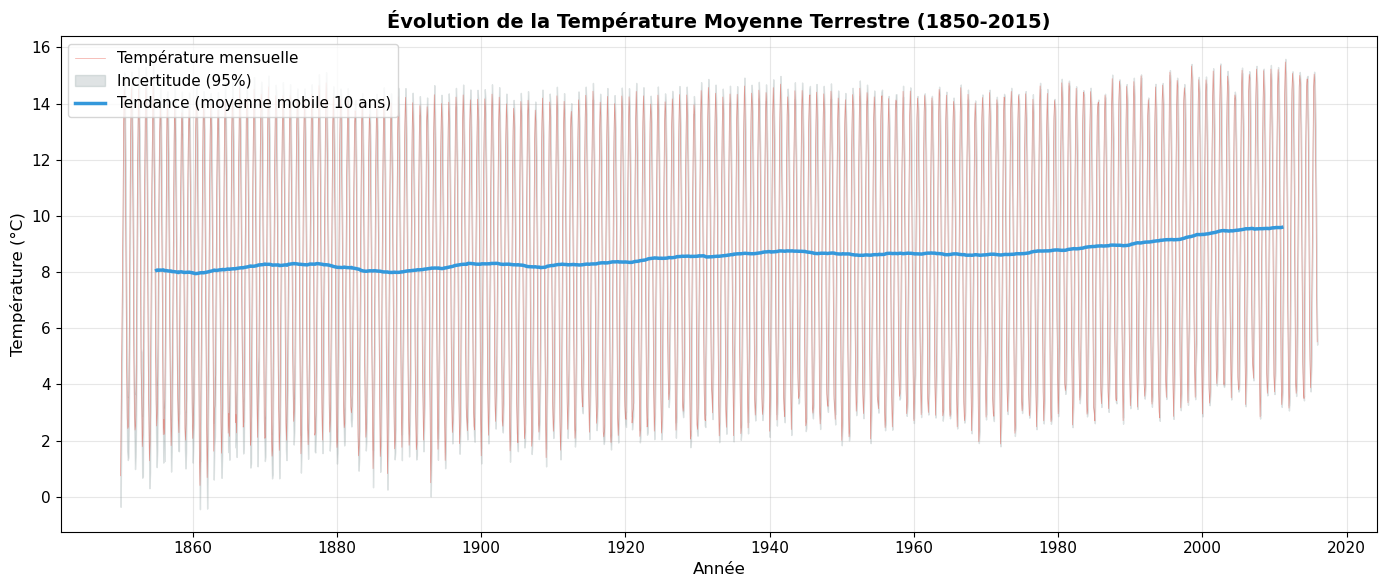

📊 STATISTIQUES PAR PÉRIODE HISTORIQUE


Période                   Description  Temp. Moyenne (°C)  \
0  1850-1900  Ère pré-industrielle tardive                8.13   
1  1900-1950     Industrialisation massive                8.48   
2  1950-2000                  Accélération                8.80   
3  2000-2015               Période récente                9.52   

   Écart-type (°C)  
0             4.38  
1             4.23  
2             4.16  
3             4.16


📈 Taux de réchauffement par période :
   1850-1900 → 1900-1950 : +0.35°C
   1900-1950 → 1950-2000 : +0.32°C
   1950-2000 → 2000-2015 : +0.72°C

🏆 TOP 5 RECORDS

🔥 Top 5 des mois les plus CHAUDS :
   1. July 2011 : 15.48°C
   2. July 2002 : 15.35°C
   3. July 1998 : 15.34°C
   4. July 2009 : 15.23°C
   5. July 2007 : 15.23°C

❄️  Top 5 des mois les plus FROIDS :
   1. January 1861 : 0.40°C
   2. January 1893 : 0.50°C
   3. January 1862 : 0.69°C
   4. January 1850 : 0.75°C
   5. January 1887 : 0.82°C

🔥 Top 5 des ANNÉES les plus chaudes :
   1. 2015 : 9.83°C
   2. 2007 : 9.73°C
   3. 2010 : 9.70°C
   4. 2005 : 9.70°C
   5. 2013 : 9.61°C

❄️  Top 5 des ANNÉES les plus froides :
   1. 1862 : 7.56°C
   2. 1857 : 7.76°C
   3. 1884 : 7.77°C
   4. 1861 : 7.85°C
   5. 1875 : 7.86°C

📊 Top 5 des plus grandes AMPLITUDES thermiques (Max-Min) :
   1. May 1875 : 13.35°C
   2. March 1872 : 13.32°C
   3. April 1856 : 13.14°C
   4. June 1875 : 13.11°C
   5. March 1884 : 13.00°C

🌍 COMPARAISON TERRE vs

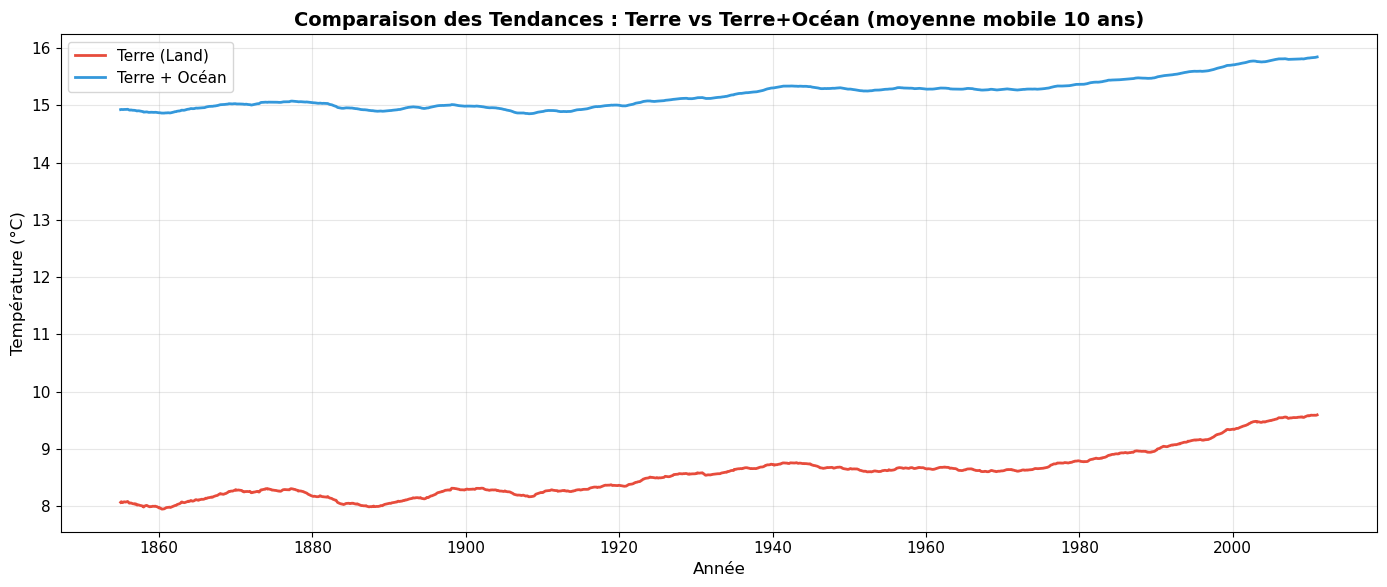

   Température moyenne Terre : 8.57°C
   Température moyenne Terre+Océan : 15.21°C
   Différence moyenne : -6.64°C (terre+océan plus chaud)

📉 ÉVOLUTION DE L'INCERTITUDE


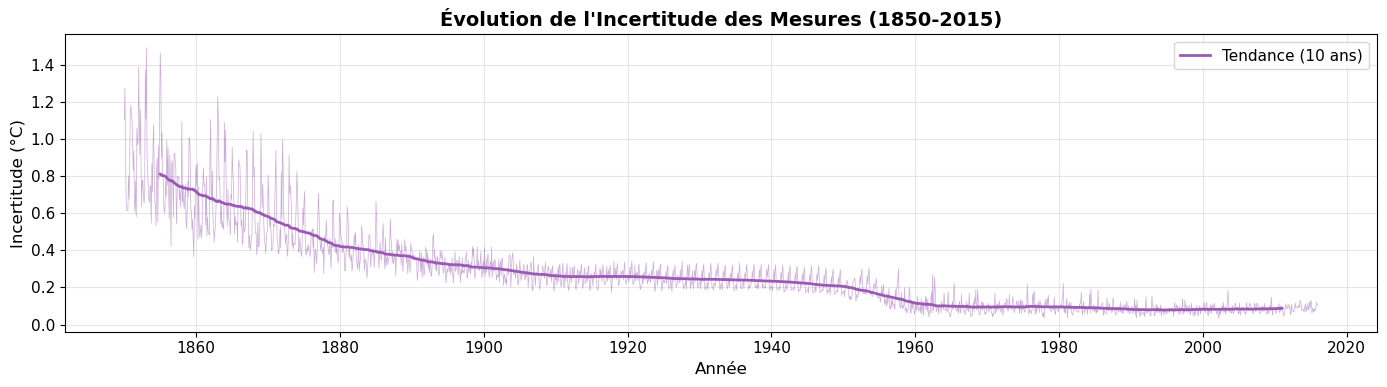

   Incertitude moyenne (1850-1860) : ±0.79°C
   Incertitude moyenne (2005-2015) : ±0.09°C
   Réduction : 89.1% (instruments plus précis)


In [7]:
# ============================================================
# 6.1 SÉRIE TEMPORELLE COMPLÈTE & STATISTIQUES DESCRIPTIVES
# ============================================================

# --- 1. GRAPHIQUE SÉRIE TEMPORELLE ---
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['LandAverageTemperature'], 
        color=COLORS['temperature'], alpha=0.5, linewidth=0.5, 
        label='Température mensuelle')

ax.fill_between(df.index,
                df['LandAverageTemperature'] - df['LandAverageTemperatureUncertainty'],
                df['LandAverageTemperature'] + df['LandAverageTemperatureUncertainty'],
                color=COLORS['uncertainty'], alpha=0.3, 
                label='Incertitude (95%)')

ax.plot(df.index, df['RollingMean_120'], 
        color=COLORS['trend'], linewidth=2.5, 
        label='Tendance (moyenne mobile 10 ans)')

ax.set_xlabel('Année')
ax.set_ylabel('Température (°C)')
ax.set_title('Évolution de la Température Moyenne Terrestre (1850-2015)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. STATISTIQUES PAR PÉRIODE HISTORIQUE ---
print("="*70)
print("📊 STATISTIQUES PAR PÉRIODE HISTORIQUE")
print("="*70)

periods = [
    ('1850-1900', 1850, 1900, 'Ère pré-industrielle tardive'),
    ('1900-1950', 1900, 1950, 'Industrialisation massive'),
    ('1950-2000', 1950, 2000, 'Accélération'),
    ('2000-2015', 2000, 2015, 'Période récente')
]

period_stats = []
for name, start, end, description in periods:
    mask = (df['Year'] >= start) & (df['Year'] < end)
    temp_mean = df.loc[mask, 'LandAverageTemperature'].mean()
    temp_std = df.loc[mask, 'LandAverageTemperature'].std()
    period_stats.append({
        'Période': name,
        'Description': description,
        'Temp. Moyenne (°C)': round(temp_mean, 2),
        'Écart-type (°C)': round(temp_std, 2)
    })

period_df = pd.DataFrame(period_stats)
display(period_df)

# Calcul du taux de réchauffement par période
print("\n📈 Taux de réchauffement par période :")
for i in range(1, len(period_stats)):
    diff = period_stats[i]['Temp. Moyenne (°C)'] - period_stats[i-1]['Temp. Moyenne (°C)']
    print(f"   {period_stats[i-1]['Période']} → {period_stats[i]['Période']} : {diff:+.2f}°C")

# --- 3. TOP 5 RECORDS ---
print("\n" + "="*70)
print("🏆 TOP 5 RECORDS")
print("="*70)

# Top 5 mois les plus chauds
print("\n🔥 Top 5 des mois les plus CHAUDS :")
top5_hot = df.nlargest(5, 'LandAverageTemperature')[['LandAverageTemperature', 'Year', 'Month']]
for i, (idx, row) in enumerate(top5_hot.iterrows(), 1):
    print(f"   {i}. {idx.strftime('%B %Y')} : {row['LandAverageTemperature']:.2f}°C")

# Top 5 mois les plus froids
print("\n❄️  Top 5 des mois les plus FROIDS :")
top5_cold = df.nsmallest(5, 'LandAverageTemperature')[['LandAverageTemperature', 'Year', 'Month']]
for i, (idx, row) in enumerate(top5_cold.iterrows(), 1):
    print(f"   {i}. {idx.strftime('%B %Y')} : {row['LandAverageTemperature']:.2f}°C")

# Top 5 années les plus chaudes
print("\n🔥 Top 5 des ANNÉES les plus chaudes :")
yearly_temp = df.groupby('Year')['LandAverageTemperature'].mean()
top5_hot_years = yearly_temp.nlargest(5)
for i, (year, temp) in enumerate(top5_hot_years.items(), 1):
    print(f"   {i}. {year} : {temp:.2f}°C")

# Top 5 années les plus froides
print("\n❄️  Top 5 des ANNÉES les plus froides :")
top5_cold_years = yearly_temp.nsmallest(5)
for i, (year, temp) in enumerate(top5_cold_years.items(), 1):
    print(f"   {i}. {year} : {temp:.2f}°C")

# Top 5 plus grandes amplitudes thermiques
print("\n📊 Top 5 des plus grandes AMPLITUDES thermiques (Max-Min) :")
top5_amplitude = df.nlargest(5, 'Amplitude')[['Amplitude', 'Year', 'Month']]
for i, (idx, row) in enumerate(top5_amplitude.iterrows(), 1):
    print(f"   {i}. {idx.strftime('%B %Y')} : {row['Amplitude']:.2f}°C")


# --- 4. COMPARAISON LAND vs OCEAN ---
print("\n" + "="*70)
print("🌍 COMPARAISON TERRE vs OCÉAN")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['RollingMean_120'], 
        color=COLORS['temperature'], linewidth=2, label='Terre (Land)')
ax.plot(df.index, df['LandAndOceanAverageTemperature'].rolling(window=120, center=True).mean(), 
        color=COLORS['trend'], linewidth=2, label='Terre + Océan')

ax.set_xlabel('Année')
ax.set_ylabel('Température (°C)')
ax.set_title('Comparaison des Tendances : Terre vs Terre+Océan (moyenne mobile 10 ans)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

land_mean = df['LandAverageTemperature'].mean()
ocean_mean = df['LandAndOceanAverageTemperature'].mean()
diff = land_mean - ocean_mean

print(f"   Température moyenne Terre : {land_mean:.2f}°C")
print(f"   Température moyenne Terre+Océan : {ocean_mean:.2f}°C")
if diff > 0:
    print(f"   Différence moyenne : {diff:+.2f}°C (terre seule plus chaude)")
else:
    print(f"   Différence moyenne : {diff:+.2f}°C (terre+océan plus chaud)")

# --- 5. ÉVOLUTION DE L'INCERTITUDE ---
print("\n" + "="*70)
print("📉 ÉVOLUTION DE L'INCERTITUDE")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(df.index, df['LandAverageTemperatureUncertainty'], 
        color=COLORS['anomaly'], alpha=0.5, linewidth=0.5)
ax.plot(df.index, df['LandAverageTemperatureUncertainty'].rolling(window=120, center=True).mean(), 
        color=COLORS['anomaly'], linewidth=2, label='Tendance (10 ans)')

ax.set_xlabel('Année')
ax.set_ylabel('Incertitude (°C)')
ax.set_title('Évolution de l\'Incertitude des Mesures (1850-2015)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

uncert_1850 = df[df['Year'] <= 1860]['LandAverageTemperatureUncertainty'].mean()
uncert_2015 = df[df['Year'] >= 2005]['LandAverageTemperatureUncertainty'].mean()
print(f"   Incertitude moyenne (1850-1860) : ±{uncert_1850:.2f}°C")
print(f"   Incertitude moyenne (2005-2015) : ±{uncert_2015:.2f}°C")
print(f"   Réduction : {((uncert_1850 - uncert_2015) / uncert_1850 * 100):.1f}% (instruments plus précis)")

### 6.1.1 Analyse des résultats

#### Évolution globale de la température

La série temporelle révèle une **tendance au réchauffement claire et indiscutable** sur les 166 années d'observation. La température moyenne terrestre est passée de **7.90°C en 1850** à **9.83°C en 2015**, soit une augmentation de **+1.93°C**.

La tendance lissée (moyenne mobile sur 10 ans) montre :
- Une relative stabilité entre 1850 et 1910 (~8°C)
- Une première phase de réchauffement entre 1910 et 1945
- Un plateau entre 1945 et 1975
- Une **accélération marquée à partir de 1980**

#### Accélération du réchauffement

L'analyse par période historique confirme une **accélération du phénomène** :

| Transition | Réchauffement | Durée | Taux annuel |
|------------|---------------|-------|-------------|
| 1850-1900 → 1900-1950 | +0.35°C | 50 ans | +0.007°C/an |
| 1900-1950 → 1950-2000 | +0.32°C | 50 ans | +0.006°C/an |
| 1950-2000 → 2000-2015 | **+0.72°C** | **15 ans** | **+0.048°C/an** |

Le taux de réchauffement de la période récente (2000-2015) est **7 fois plus rapide** que celui du début du 20ème siècle.

#### Analyse des records

**Mois les plus chauds :**
- Les 5 mois les plus chauds sont **tous des mois de juillet** et **tous postérieurs à 1998**
- Record : **Juillet 2011 (15.48°C)**
- Cela suggère que les extrêmes chauds se concentrent dans la période récente

**Mois les plus froids :**
- Les 5 mois les plus froids sont **tous des mois de janvier** et **tous au 19ème siècle** (1850-1893)
- Record : **Janvier 1861 (0.40°C)**
- Les hivers extrêmement froids semblent avoir disparu du registre moderne

**Années les plus chaudes :**
- Les 5 années les plus chaudes sont **toutes après 2005** (2015, 2007, 2010, 2005, 2013)
- Cela confirme l'accélération récente du réchauffement

**Amplitudes thermiques :**
- Les plus grandes amplitudes (Max-Min) se situent principalement au **19ème siècle**
- Cela pourrait refléter une plus grande incertitude des mesures anciennes ou des événements climatiques extrêmes

#### Comparaison Terre vs Océan

La température moyenne Terre+Océan (15.21°C) est supérieure à celle de la Terre seule (8.57°C), avec une différence de **-6.64°C**. Cette différence s'explique par :
- La capacité thermique des océans (régulation thermique)
- La méthodologie de calcul différente entre les deux variables

Les deux courbes montrent cependant une **tendance parallèle au réchauffement**, confirmant le caractère global du phénomène.

#### Évolution de l'incertitude

L'incertitude des mesures a été **réduite de 89%** entre 1850 et 2015 :
- 1850-1860 : ±0.79°C
- 2005-2015 : ±0.09°C

Cette amélioration reflète :
- Le développement du réseau de stations météorologiques
- L'amélioration des instruments de mesure
- La standardisation des protocoles de relevé

**Implication pour notre analyse :** Les anomalies détectées dans les données récentes seront plus fiables que celles des données anciennes.

### 6.2 Analyse de la saisonnalité

La saisonnalité est le pattern dominant dans les séries de température. Avant de détecter des anomalies, il est essentiel de comprendre ce cycle "normal" et d'observer s'il évolue au fil du temps.

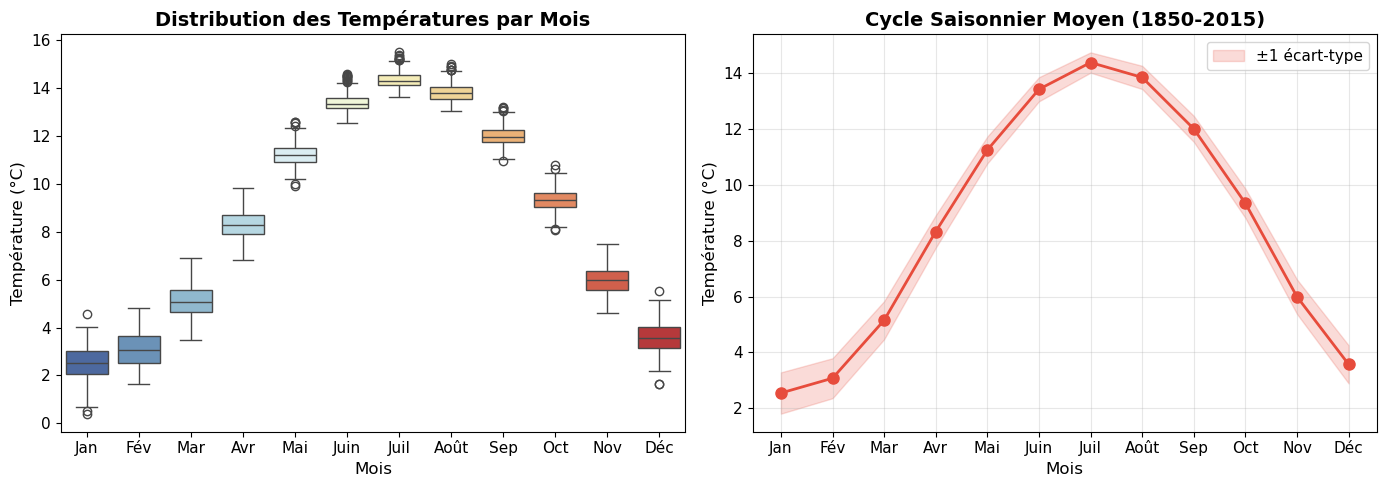

📊 STATISTIQUES DU CYCLE SAISONNIER

   Mois le plus chaud : Juil (14.37°C)
   Mois le plus froid : Jan (2.55°C)
   Amplitude saisonnière : 11.82°C

📈 ÉVOLUTION DE LA SAISONNALITÉ


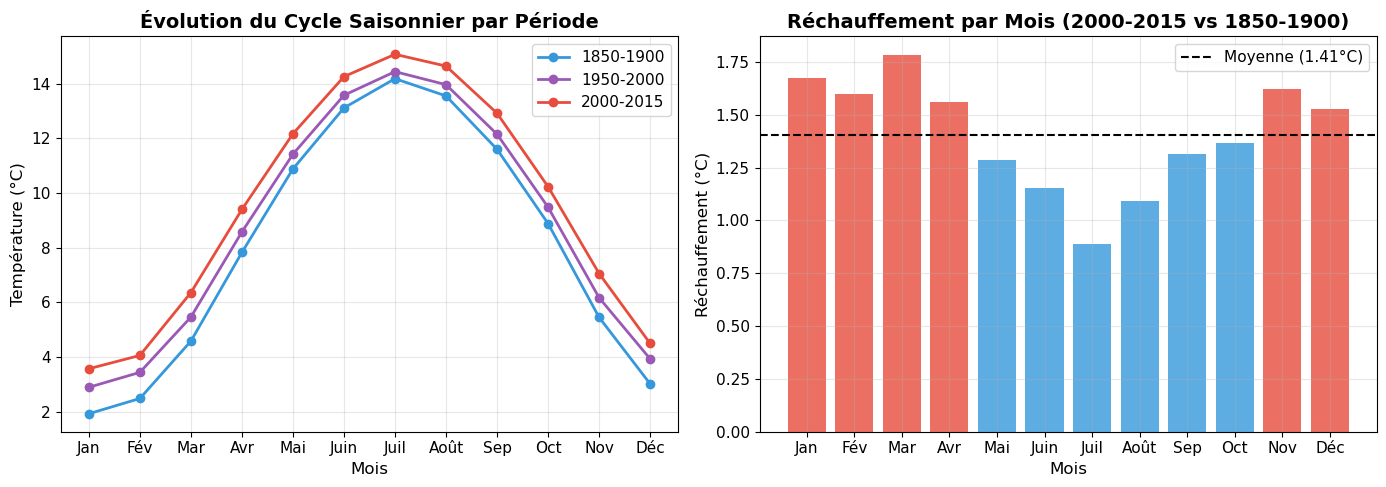


   Mois avec le plus de réchauffement : Mar (+1.78°C)
   Mois avec le moins de réchauffement : Juil (+0.89°C)

📊 DISTRIBUTION DES ANOMALIES MENSUELLES


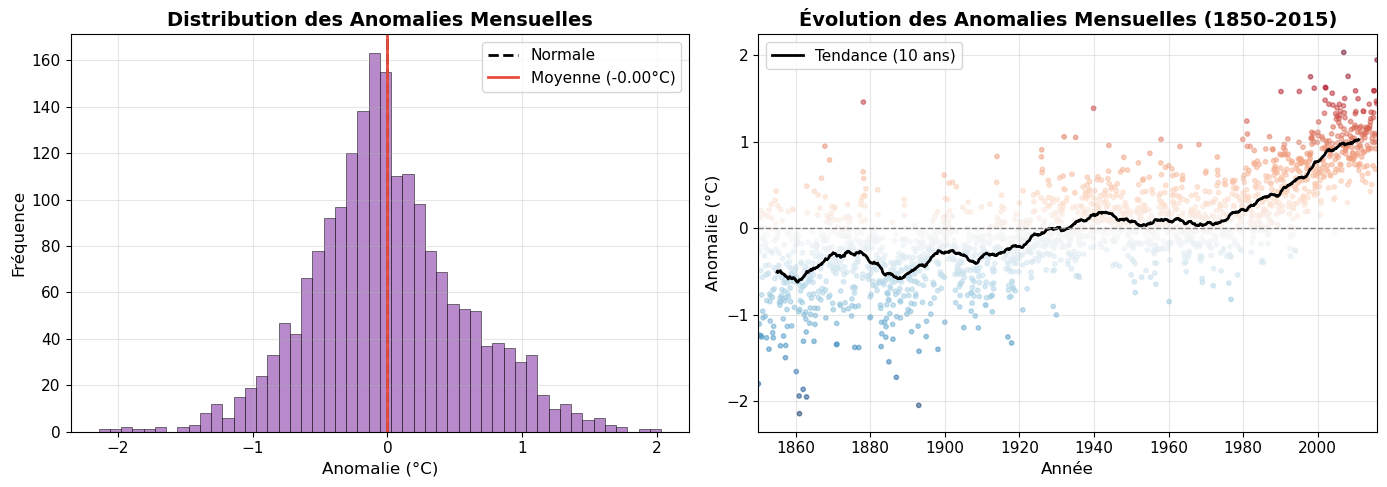


   Anomalie moyenne : -0.000°C
   Écart-type : 0.57°C
   Anomalie min : -2.14°C
   Anomalie max : 2.03°C

   Anomalies positives (1850-1900) : 11.8%
   Anomalies positives (2000-2015) : 99.5%


In [8]:
# ============================================================
# 6.2 ANALYSE DE LA SAISONNALITÉ
# ============================================================

# --- Noms des mois pour les graphiques ---
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 
               'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

# --- 1. DISTRIBUTION MENSUELLE (Boxplot) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='Month', y='LandAverageTemperature', 
            palette='RdYlBu_r', ax=axes[0])
axes[0].set_xticklabels(month_names)
axes[0].set_xlabel('Mois')
axes[0].set_ylabel('Température (°C)')
axes[0].set_title('Distribution des Températures par Mois', fontweight='bold')

# Cycle saisonnier moyen
monthly_mean = df.groupby('Month')['LandAverageTemperature'].mean()
monthly_std = df.groupby('Month')['LandAverageTemperature'].std()

axes[1].plot(range(1, 13), monthly_mean.values, 
             color=COLORS['temperature'], linewidth=2, marker='o', markersize=8)
axes[1].fill_between(range(1, 13), 
                     monthly_mean.values - monthly_std.values,
                     monthly_mean.values + monthly_std.values,
                     color=COLORS['temperature'], alpha=0.2, label='±1 écart-type')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Température (°C)')
axes[1].set_title('Cycle Saisonnier Moyen (1850-2015)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques du cycle saisonnier
print("="*70)
print("📊 STATISTIQUES DU CYCLE SAISONNIER")
print("="*70)
print(f"\n   Mois le plus chaud : {month_names[monthly_mean.idxmax()-1]} ({monthly_mean.max():.2f}°C)")
print(f"   Mois le plus froid : {month_names[monthly_mean.idxmin()-1]} ({monthly_mean.min():.2f}°C)")
print(f"   Amplitude saisonnière : {monthly_mean.max() - monthly_mean.min():.2f}°C")

# --- 2. ÉVOLUTION DE LA SAISONNALITÉ AU FIL DU TEMPS ---
print("\n" + "="*70)
print("📈 ÉVOLUTION DE LA SAISONNALITÉ")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparaison du cycle saisonnier entre périodes
periods_seasonality = [
    ('1850-1900', 1850, 1900, COLORS['trend']),
    ('1950-2000', 1950, 2000, COLORS['anomaly']),
    ('2000-2015', 2000, 2015, COLORS['temperature'])
]

for name, start, end, color in periods_seasonality:
    mask = (df['Year'] >= start) & (df['Year'] < end)
    monthly_period = df[mask].groupby('Month')['LandAverageTemperature'].mean()
    axes[0].plot(range(1, 13), monthly_period.values, 
                 linewidth=2, marker='o', label=name, color=color)

axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].set_xlabel('Mois')
axes[0].set_ylabel('Température (°C)')
axes[0].set_title('Évolution du Cycle Saisonnier par Période', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Réchauffement par mois
warming_by_month = []
for month in range(1, 13):
    temp_early = df[(df['Month'] == month) & (df['Year'] <= 1900)]['LandAverageTemperature'].mean()
    temp_late = df[(df['Month'] == month) & (df['Year'] >= 2000)]['LandAverageTemperature'].mean()
    warming_by_month.append(temp_late - temp_early)

colors_warming = [COLORS['temperature'] if w > np.mean(warming_by_month) else COLORS['trend'] 
                  for w in warming_by_month]
bars = axes[1].bar(range(1, 13), warming_by_month, color=colors_warming, alpha=0.8)
axes[1].axhline(y=np.mean(warming_by_month), color='black', linestyle='--', 
                label=f'Moyenne ({np.mean(warming_by_month):.2f}°C)')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Réchauffement (°C)')
axes[1].set_title('Réchauffement par Mois (2000-2015 vs 1850-1900)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mois avec le plus/moins de réchauffement
max_warming_month = month_names[np.argmax(warming_by_month)]
min_warming_month = month_names[np.argmin(warming_by_month)]
print(f"\n   Mois avec le plus de réchauffement : {max_warming_month} (+{max(warming_by_month):.2f}°C)")
print(f"   Mois avec le moins de réchauffement : {min_warming_month} (+{min(warming_by_month):.2f}°C)")

# --- 3. DISTRIBUTION DES ANOMALIES MENSUELLES ---
print("\n" + "="*70)
print("📊 DISTRIBUTION DES ANOMALIES MENSUELLES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des anomalies
axes[0].hist(df['MonthlyAnomaly'], bins=50, color=COLORS['anomaly'], 
             alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Normale')
axes[0].axvline(x=df['MonthlyAnomaly'].mean(), color=COLORS['temperature'], 
                linestyle='-', linewidth=2, label=f"Moyenne ({df['MonthlyAnomaly'].mean():.2f}°C)")
axes[0].set_xlabel('Anomalie (°C)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Anomalies Mensuelles', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Évolution des anomalies dans le temps
axes[1].scatter(df.index, df['MonthlyAnomaly'], 
                c=df['MonthlyAnomaly'], cmap='RdBu_r', 
                alpha=0.5, s=10)
axes[1].plot(df.index, df['MonthlyAnomaly'].rolling(window=120, center=True).mean(),
             color='black', linewidth=2, label='Tendance (10 ans)')
axes[1].axhline(y=0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlim(df.index.min(), df.index.max())  # <-- CORRECTION ICI
axes[1].set_xlabel('Année')
axes[1].set_ylabel('Anomalie (°C)')
axes[1].set_title('Évolution des Anomalies Mensuelles (1850-2015)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des anomalies
print(f"\n   Anomalie moyenne : {df['MonthlyAnomaly'].mean():.3f}°C")
print(f"   Écart-type : {df['MonthlyAnomaly'].std():.2f}°C")
print(f"   Anomalie min : {df['MonthlyAnomaly'].min():.2f}°C")
print(f"   Anomalie max : {df['MonthlyAnomaly'].max():.2f}°C")

# Pourcentage d'anomalies positives par période
print(f"\n   Anomalies positives (1850-1900) : {(df[(df['Year'] >= 1850) & (df['Year'] < 1900)]['MonthlyAnomaly'] > 0).mean()*100:.1f}%")
print(f"   Anomalies positives (2000-2015) : {(df[(df['Year'] >= 2000) & (df['Year'] <= 2015)]['MonthlyAnomaly'] > 0).mean()*100:.1f}%")

### 6.2.1 Analyse des résultats

#### Cycle saisonnier

La série présente un **cycle saisonnier très marqué** avec une amplitude de **11.82°C** entre :
- Le mois le plus chaud : **Juillet (14.37°C)**
- Le mois le plus froid : **Janvier (2.55°C)**

Ce cycle correspond à la saisonnalité de l'hémisphère Nord, qui domine les mesures terrestres globales (plus grande surface de terres émergées).

#### Évolution de la saisonnalité dans le temps

Le graphique de comparaison entre périodes révèle un **décalage vertical uniforme** : le cycle saisonnier conserve sa forme mais se déplace vers le haut (réchauffement global).

**Observation clé :** Le réchauffement n'est pas uniforme selon les mois :

| Réchauffement | Mois concernés | Interprétation |
|---------------|----------------|----------------|
| **Plus fort (+1.6 à +1.8°C)** | Janvier, Février, Mars, Avril | Les hivers et printemps se réchauffent plus vite |
| **Plus faible (+0.9 à +1.1°C)** | Juin, Juillet, Août | Les étés se réchauffent moins vite |

Le mois de **Mars** montre le réchauffement le plus important (**+1.78°C**), tandis que **Juillet** montre le réchauffement le plus faible (**+0.89°C**).

**Implication climatologique :** Ce phénomène, appelé "amplification hivernale", est cohérent avec les modèles climatiques qui prédisent un réchauffement plus prononcé aux hautes latitudes et en hiver, notamment dû à la rétroaction glace-albédo.

#### Distribution des anomalies mensuelles

La variable `MonthlyAnomaly` (écart à la moyenne historique du mois) présente :
- Une **distribution quasi-normale** centrée sur 0
- Un écart-type de **0.57°C**
- Des valeurs extrêmes entre **-2.14°C** et **+2.03°C**

#### Évolution temporelle des anomalies

Le graphique d'évolution des anomalies est **particulièrement révélateur** :

| Période | Anomalies positives | Interprétation |
|---------|---------------------|----------------|
| 1850-1900 | **11.8%** | Période majoritairement "froide" par rapport à la moyenne historique |
| 2000-2015 | **99.5%** | Quasi-totalité des mois sont au-dessus de la normale |

Ce basculement spectaculaire (de 11.8% à 99.5%) illustre de manière frappante le changement climatique : ce qui était "normal" au 19ème siècle est devenu systématiquement inférieur aux températures actuelles.

La tendance lissée (courbe noire) montre clairement :
- Anomalies négatives jusqu'aux années 1930
- Transition autour de 1980
- Anomalies systématiquement positives et croissantes depuis 1990

**Cette variable `MonthlyAnomaly` sera centrale pour notre détection d'anomalies**, car elle capture précisément les écarts au comportement saisonnier attendu.

### 6.3 Tests de Stationnarité

Une série temporelle est dite **stationnaire** si ses propriétés statistiques (moyenne, variance) ne changent pas dans le temps. C'est une hypothèse importante pour de nombreux modèles de séries temporelles.

**Tests utilisés :**

| Test | Hypothèse nulle (H0) | Rejet si p-value < 0.05 |
|------|----------------------|-------------------------|
| **ADF (Augmented Dickey-Fuller)** | La série a une racine unitaire (non stationnaire) | Série stationnaire |
| **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)** | La série est stationnaire | Série non stationnaire |

**Séries testées :**
- `LandAverageTemperature` : Série brute (attendue non stationnaire)
- `MonthlyAnomaly` : Série désaisonnalisée (potentiellement stationnaire)

L'utilisation conjointe des deux tests permet une conclusion plus robuste.


📊 TESTS DE STATIONNARITÉ : LandAverageTemperature (série brute)

📈 Test ADF (Augmented Dickey-Fuller)
   H0 : La série est NON stationnaire (présence de racine unitaire)
   Statistique ADF : -1.4553
   P-value : 0.5555
   Valeurs critiques :
      1%: -3.4337
      5%: -2.8630
      10%: -2.5676
   ❌ Conclusion ADF : Série NON STATIONNAIRE (p-value >= 0.05, on ne rejette pas H0)

📉 Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
   H0 : La série est STATIONNAIRE
   Statistique KPSS : 2.3334
   P-value : 0.0100
   Valeurs critiques :
      10%: 0.3470
      5%: 0.4630
      2.5%: 0.5740
      1%: 0.7390
   ❌ Conclusion KPSS : Série NON STATIONNAIRE (p-value < 0.05, on rejette H0)

──────────────────────────────────────────────────────────────────────
   🎯 CONCLUSION GLOBALE : Série NON STATIONNAIRE (les deux tests concordent)

📊 TESTS DE STATIONNARITÉ : MonthlyAnomaly (série désaisonnalisée)

📈 Test ADF (Augmented Dickey-Fuller)
   H0 : La série est NON stationnaire (présence de racine u

Série ADF p-value    ADF Conclusion KPSS p-value  \
0  LandAverageTemperature      0.5555  Non stationnaire       0.0100   
1          MonthlyAnomaly      0.5452  Non stationnaire       0.0100   

    KPSS Conclusion  
0  Non stationnaire  
1  Non stationnaire

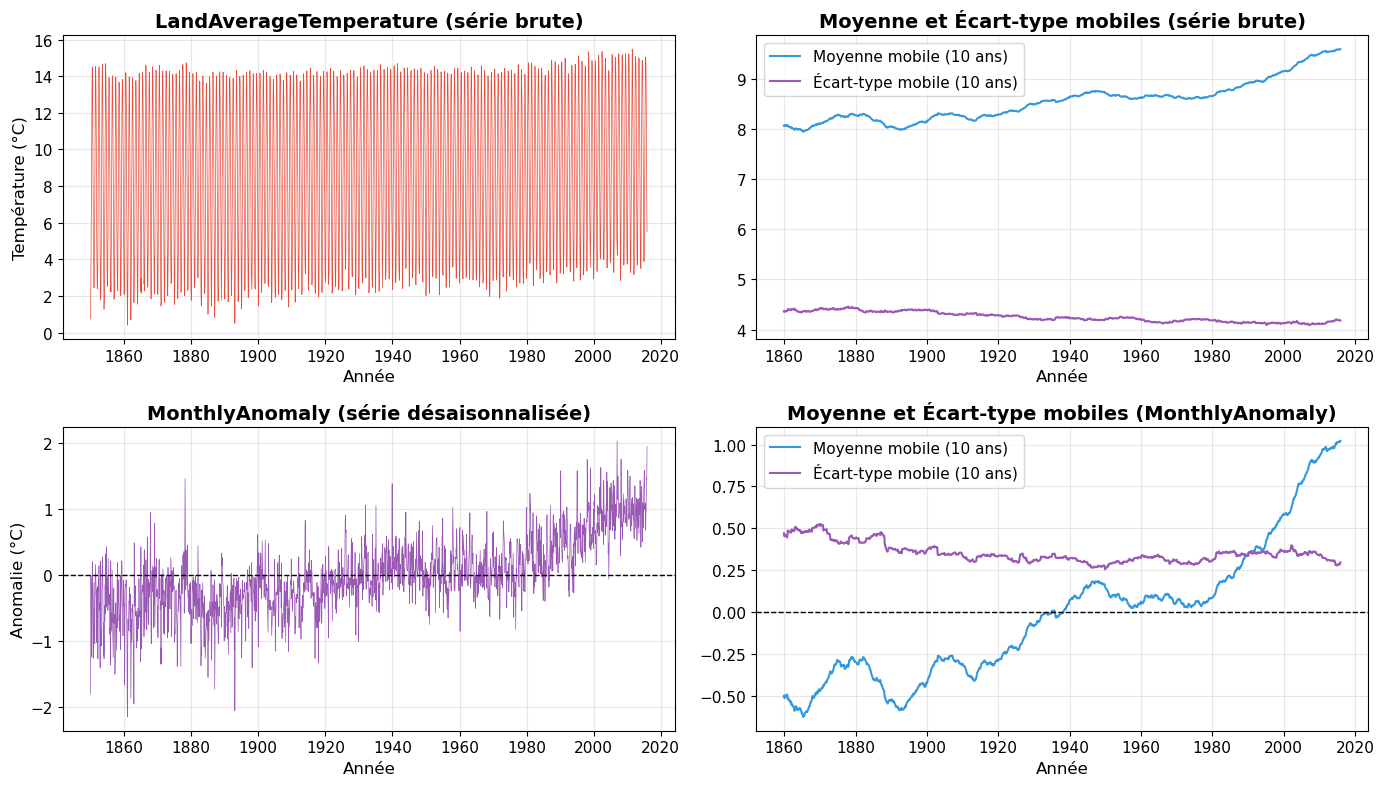


💡 INTERPRÉTATION DES GRAPHIQUES :
   - Série stationnaire → moyenne et variance constantes dans le temps
   - Série non stationnaire → tendance visible dans la moyenne mobile


In [9]:
# ============================================================
# 6.3 TESTS DE STATIONNARITÉ
# ============================================================

from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, name):
    """
    Effectue les tests ADF et KPSS sur une série temporelle.
    Retourne un dictionnaire avec les résultats.
    """
    # Supprimer les NaN pour les tests
    series_clean = series.dropna()
    
    # --- Test ADF ---
    adf_result = adfuller(series_clean, autolag='AIC')
    adf_statistic = adf_result[0]
    adf_pvalue = adf_result[1]
    adf_critical = adf_result[4]
    
    # --- Test KPSS ---
    kpss_result = kpss(series_clean, regression='c', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_pvalue = kpss_result[1]
    kpss_critical = kpss_result[3]
    
    return {
        'name': name,
        'adf_stat': adf_statistic,
        'adf_pvalue': adf_pvalue,
        'adf_critical': adf_critical,
        'kpss_stat': kpss_statistic,
        'kpss_pvalue': kpss_pvalue,
        'kpss_critical': kpss_critical
    }

def print_stationarity_results(results):
    """Affiche les résultats des tests de stationnarité."""
    print(f"\n{'='*70}")
    print(f"📊 TESTS DE STATIONNARITÉ : {results['name']}")
    print(f"{'='*70}")
    
    # Résultats ADF
    print(f"\n📈 Test ADF (Augmented Dickey-Fuller)")
    print(f"   H0 : La série est NON stationnaire (présence de racine unitaire)")
    print(f"   Statistique ADF : {results['adf_stat']:.4f}")
    print(f"   P-value : {results['adf_pvalue']:.4f}")
    print(f"   Valeurs critiques :")
    for key, value in results['adf_critical'].items():
        print(f"      {key}: {value:.4f}")
    
    if results['adf_pvalue'] < 0.05:
        print(f"   ✅ Conclusion ADF : Série STATIONNAIRE (p-value < 0.05, on rejette H0)")
    else:
        print(f"   ❌ Conclusion ADF : Série NON STATIONNAIRE (p-value >= 0.05, on ne rejette pas H0)")
    
    # Résultats KPSS
    print(f"\n📉 Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)")
    print(f"   H0 : La série est STATIONNAIRE")
    print(f"   Statistique KPSS : {results['kpss_stat']:.4f}")
    print(f"   P-value : {results['kpss_pvalue']:.4f}")
    print(f"   Valeurs critiques :")
    for key, value in results['kpss_critical'].items():
        print(f"      {key}: {value:.4f}")
    
    if results['kpss_pvalue'] < 0.05:
        print(f"   ❌ Conclusion KPSS : Série NON STATIONNAIRE (p-value < 0.05, on rejette H0)")
    else:
        print(f"   ✅ Conclusion KPSS : Série STATIONNAIRE (p-value >= 0.05, on ne rejette pas H0)")
    
    # Conclusion globale
    print(f"\n{'─'*70}")
    adf_stationary = results['adf_pvalue'] < 0.05
    kpss_stationary = results['kpss_pvalue'] >= 0.05
    
    if adf_stationary and kpss_stationary:
        print(f"   🎯 CONCLUSION GLOBALE : Série STATIONNAIRE (les deux tests concordent)")
    elif not adf_stationary and not kpss_stationary:
        print(f"   🎯 CONCLUSION GLOBALE : Série NON STATIONNAIRE (les deux tests concordent)")
    else:
        print(f"   ⚠️  CONCLUSION GLOBALE : Résultats MIXTES (tests non concordants)")

# --- Test sur la série brute ---
results_raw = test_stationarity(df['LandAverageTemperature'], 'LandAverageTemperature (série brute)')
print_stationarity_results(results_raw)

# --- Test sur MonthlyAnomaly ---
results_anomaly = test_stationarity(df['MonthlyAnomaly'], 'MonthlyAnomaly (série désaisonnalisée)')
print_stationarity_results(results_anomaly)

# --- Tableau récapitulatif ---
print(f"\n{'='*70}")
print(f"📋 TABLEAU RÉCAPITULATIF")
print(f"{'='*70}\n")

summary_data = {
    'Série': ['LandAverageTemperature', 'MonthlyAnomaly'],
    'ADF p-value': [f"{results_raw['adf_pvalue']:.4f}", f"{results_anomaly['adf_pvalue']:.4f}"],
    'ADF Conclusion': ['Non stationnaire' if results_raw['adf_pvalue'] >= 0.05 else 'Stationnaire',
                       'Non stationnaire' if results_anomaly['adf_pvalue'] >= 0.05 else 'Stationnaire'],
    'KPSS p-value': [f"{results_raw['kpss_pvalue']:.4f}", f"{results_anomaly['kpss_pvalue']:.4f}"],
    'KPSS Conclusion': ['Non stationnaire' if results_raw['kpss_pvalue'] < 0.05 else 'Stationnaire',
                        'Non stationnaire' if results_anomaly['kpss_pvalue'] < 0.05 else 'Stationnaire']
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# --- Visualisation ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Série brute
axes[0, 0].plot(df.index, df['LandAverageTemperature'], color=COLORS['temperature'], linewidth=0.5)
axes[0, 0].set_title('LandAverageTemperature (série brute)', fontweight='bold')
axes[0, 0].set_xlabel('Année')
axes[0, 0].set_ylabel('Température (°C)')
axes[0, 0].grid(True, alpha=0.3)

# Rolling mean/std série brute
rolling_mean_raw = df['LandAverageTemperature'].rolling(window=120).mean()
rolling_std_raw = df['LandAverageTemperature'].rolling(window=120).std()
axes[0, 1].plot(df.index, rolling_mean_raw, color=COLORS['trend'], label='Moyenne mobile (10 ans)')
axes[0, 1].plot(df.index, rolling_std_raw, color=COLORS['anomaly'], label='Écart-type mobile (10 ans)')
axes[0, 1].set_title('Moyenne et Écart-type mobiles (série brute)', fontweight='bold')
axes[0, 1].set_xlabel('Année')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MonthlyAnomaly
axes[1, 0].plot(df.index, df['MonthlyAnomaly'], color=COLORS['anomaly'], linewidth=0.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('MonthlyAnomaly (série désaisonnalisée)', fontweight='bold')
axes[1, 0].set_xlabel('Année')
axes[1, 0].set_ylabel('Anomalie (°C)')
axes[1, 0].grid(True, alpha=0.3)

# Rolling mean/std MonthlyAnomaly
rolling_mean_anom = df['MonthlyAnomaly'].rolling(window=120).mean()
rolling_std_anom = df['MonthlyAnomaly'].rolling(window=120).std()
axes[1, 1].plot(df.index, rolling_mean_anom, color=COLORS['trend'], label='Moyenne mobile (10 ans)')
axes[1, 1].plot(df.index, rolling_std_anom, color=COLORS['anomaly'], label='Écart-type mobile (10 ans)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Moyenne et Écart-type mobiles (MonthlyAnomaly)', fontweight='bold')
axes[1, 1].set_xlabel('Année')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRÉTATION DES GRAPHIQUES :")
print("   - Série stationnaire → moyenne et variance constantes dans le temps")
print("   - Série non stationnaire → tendance visible dans la moyenne mobile")

### 6.3.1 Analyse des résultats

#### Résultats des tests

| Série | ADF p-value | ADF Conclusion | KPSS p-value | KPSS Conclusion | Verdict |
|-------|-------------|----------------|--------------|-----------------|---------|
| `LandAverageTemperature` | 0.5555 | Non stationnaire | 0.0100 | Non stationnaire | **Non stationnaire** |
| `MonthlyAnomaly` | 0.5452 | Non stationnaire | 0.0100 | Non stationnaire | **Non stationnaire** |

Les deux tests (ADF et KPSS) concordent : **les deux séries sont non stationnaires**.

#### Interprétation

**Série brute (`LandAverageTemperature`) :**
- Non-stationnarité attendue due à la **tendance de réchauffement** et à la **saisonnalité**
- La moyenne mobile (graphique en haut à droite) montre clairement une tendance croissante

**Série désaisonnalisée (`MonthlyAnomaly`) :**
- Résultat plus surprenant : **également non stationnaire**
- Explication : la désaisonnalisation retire le cycle annuel, mais **pas la tendance long-terme**
- Le graphique (en bas à droite) montre que la moyenne des anomalies passe de -0.5°C (1850-1900) à +1.0°C (2000-2015)
- L'écart-type reste relativement stable (~0.35°C), mais la moyenne dérive

#### Implications pour la modélisation

Cette non-stationnarité a des implications importantes pour notre projet :

| Approche | Adapté ? | Commentaire |
|----------|----------|-------------|
| Modèles ARIMA classiques | ❌ | Nécessitent la stationnarité |
| Isolation Forest | ✅ | N'assume pas la stationnarité |
| LSTM Autoencoder | ⚠️ | Plus robuste, mais préfère des données stables |

#### Solutions pour obtenir une série stationnaire

Pour les modèles sensibles à la stationnarité, plusieurs options :

1. **Différenciation** : Calculer T(t) - T(t-1) ou T(t) - T(t-12)
2. **Décomposition STL** : Utiliser uniquement les **résidus** (tendance et saisonnalité retirées)
3. **Détrending** : Soustraire une tendance linéaire ou polynomiale

La section suivante (6.4) explorera la **décomposition STL** qui permettra d'isoler les résidus - la composante la plus pertinente pour la détection d'anomalies.

#### Note sur les warnings

Les warnings `InterpolationWarning` du test KPSS sont normaux : ils indiquent que la statistique de test est si extrême que la p-value réelle est inférieure à 0.01 (la limite des tables de référence). Cela renforce la conclusion de non-stationnarité.

### 6.4 Décomposition STL (Seasonal-Trend using LOESS)

La décomposition STL est une méthode robuste pour séparer une série temporelle en trois composantes additives :

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

| Composante | Description | Intérêt pour notre projet |
|------------|-------------|---------------------------|
| **Trend** | Tendance long-terme | Capture le réchauffement climatique |
| **Seasonal** | Cycle saisonnier récurrent | Capture le pattern annuel (été/hiver) |
| **Residual** | Variations inexpliquées | **Anomalies potentielles à détecter** |

Les **résidus** sont particulièrement importants : ils représentent ce qui ne peut être expliqué ni par la tendance ni par la saisonnalité. Un résidu anormalement élevé (positif ou négatif) indique un mois dont la température s'écarte significativement du comportement "normal" attendu.

📊 DÉCOMPOSITION STL
✅ Décomposition STL effectuée
   Composantes ajoutées : STL_Trend, STL_Seasonal, STL_Residual


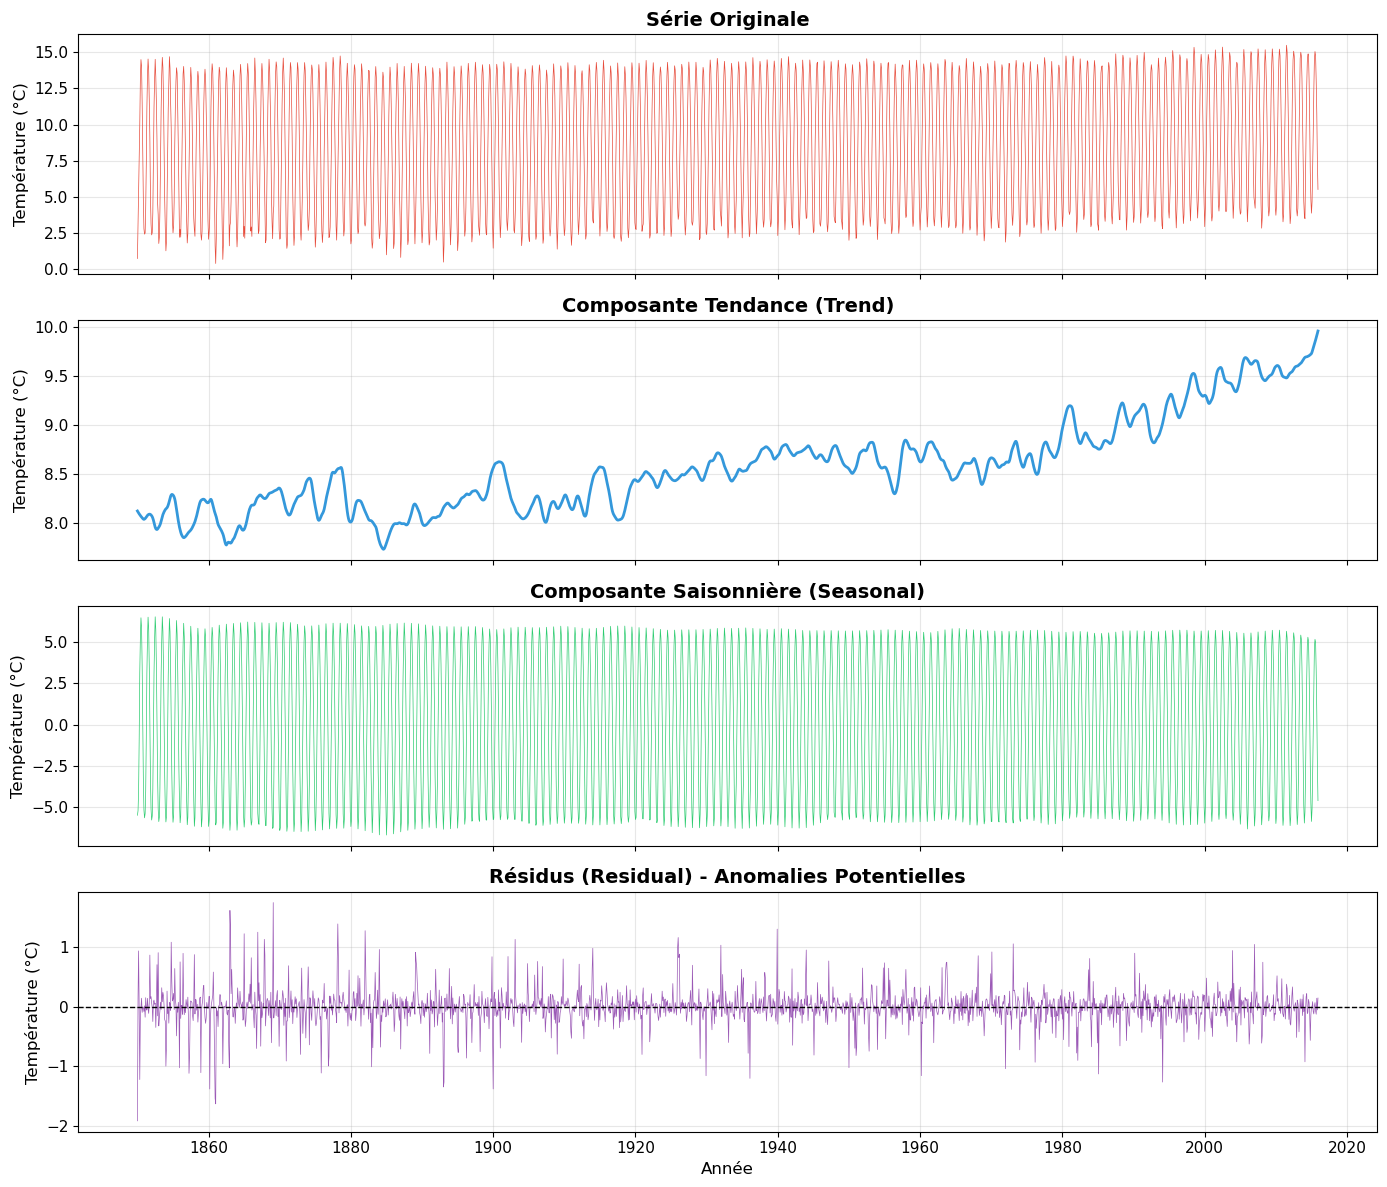


📈 STATISTIQUES DES COMPOSANTES


Composante  Moyenne  Écart-type    Min    Max
0      Trend    8.575       0.465  7.736  9.961
1   Seasonal    0.000       4.221 -6.660  6.495
2   Residual   -0.003       0.292 -1.909  1.739


📊 TEST DE STATIONNARITÉ SUR LES RÉSIDUS STL

📊 TESTS DE STATIONNARITÉ : STL_Residual

📈 Test ADF (Augmented Dickey-Fuller)
   H0 : La série est NON stationnaire (présence de racine unitaire)
   Statistique ADF : -8.8083
   P-value : 0.0000
   Valeurs critiques :
      1%: -3.4337
      5%: -2.8630
      10%: -2.5676
   ✅ Conclusion ADF : Série STATIONNAIRE (p-value < 0.05, on rejette H0)

📉 Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
   H0 : La série est STATIONNAIRE
   Statistique KPSS : 0.0704
   P-value : 0.1000
   Valeurs critiques :
      10%: 0.3470
      5%: 0.4630
      2.5%: 0.5740
      1%: 0.7390
   ✅ Conclusion KPSS : Série STATIONNAIRE (p-value >= 0.05, on ne rejette pas H0)

──────────────────────────────────────────────────────────────────────
   🎯 CONCLUSION GLOBALE : Série STATIONNAIRE (les deux tests concordent)

📊 DISTRIBUTION DES RÉSIDUS


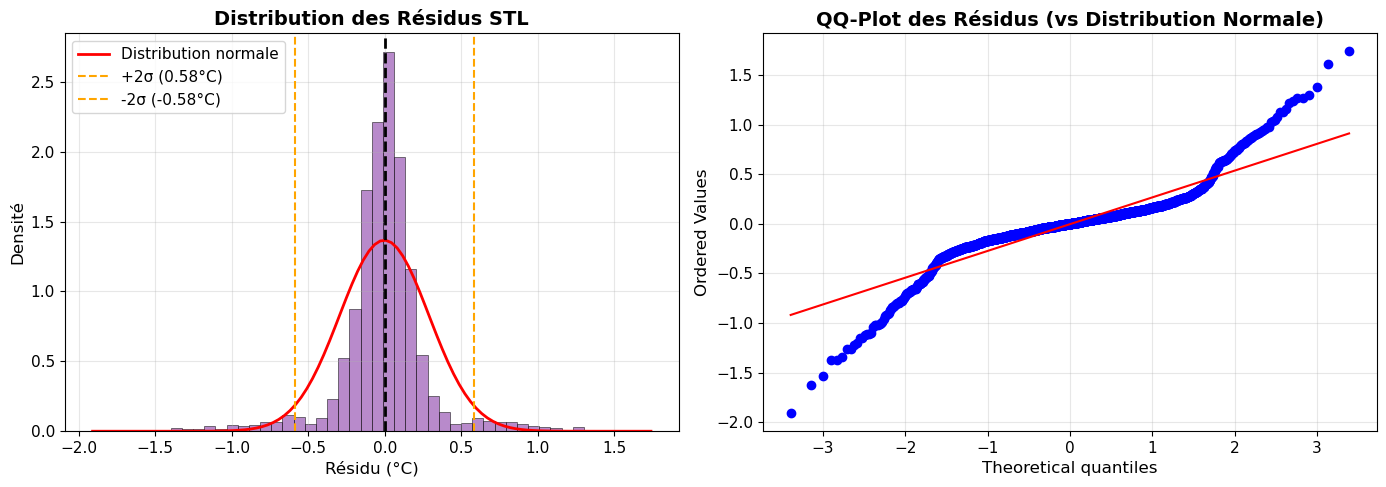


   Test de normalité (Shapiro-Wilk) :
   Statistique : 0.8670
   P-value : 0.0000
   ❌ Les résidus ne suivent PAS une distribution normale (p < 0.05)

🔍 IDENTIFICATION DES ANOMALIES (RÉSIDUS EXTRÊMES)

   Seuil de détection : ±0.58°C (2 écarts-types)
   Nombre d'anomalies positives (mois trop chauds) : 72
   Nombre d'anomalies négatives (mois trop froids) : 74
   Total : 146 anomalies (7.3%)

🔥 Top 5 des mois ANORMALEMENT CHAUDS :
   1. February 1869 : résidu = +1.74°C
   2. January 1863 : résidu = +1.61°C
   3. March 1878 : résidu = +1.38°C
   4. December 1939 : résidu = +1.30°C
   5. February 1863 : résidu = +1.27°C

❄️  Top 5 des mois ANORMALEMENT FROIDS :
   1. January 1850 : résidu = -1.91°C
   2. January 1861 : résidu = -1.63°C
   3. December 1860 : résidu = -1.53°C
   4. March 1860 : résidu = -1.38°C
   5. January 1900 : résidu = -1.38°C


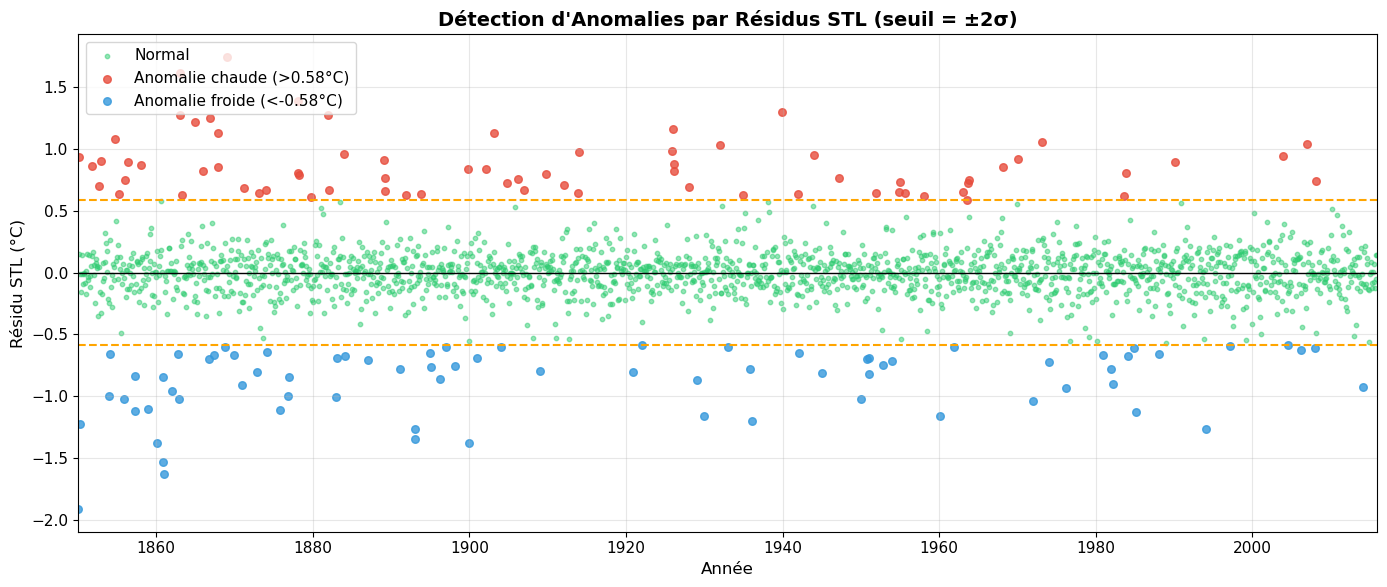


📊 RÉPARTITION TEMPORELLE DES ANOMALIES
   1850-1900: 34 chaudes, 37 froides (71 total, 11.8%)
   1900-1950: 20 chaudes, 13 froides (33 total, 5.5%)
   1950-2000: 15 chaudes, 20 froides (35 total, 5.8%)
   2000-2015: 3 chaudes, 4 froides (7 total, 3.9%)


In [10]:
# ============================================================
# 6.4 DÉCOMPOSITION STL
# ============================================================

from statsmodels.tsa.seasonal import STL

# --- 1. DÉCOMPOSITION STL ---
print("="*70)
print("📊 DÉCOMPOSITION STL")
print("="*70)

# Paramètres STL
# period=12 car données mensuelles (cycle annuel)
# robust=True pour réduire l'influence des outliers
stl = STL(df['LandAverageTemperature'], period=12, robust=True)
result = stl.fit()

# Stocker les composantes dans le dataframe
df['STL_Trend'] = result.trend
df['STL_Seasonal'] = result.seasonal
df['STL_Residual'] = result.resid

print("✅ Décomposition STL effectuée")
print(f"   Composantes ajoutées : STL_Trend, STL_Seasonal, STL_Residual")

# --- 2. VISUALISATION DES COMPOSANTES ---
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Série originale
axes[0].plot(df.index, df['LandAverageTemperature'], 
             color=COLORS['temperature'], linewidth=0.5)
axes[0].set_ylabel('Température (°C)')
axes[0].set_title('Série Originale', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tendance
axes[1].plot(df.index, df['STL_Trend'], 
             color=COLORS['trend'], linewidth=2)
axes[1].set_ylabel('Température (°C)')
axes[1].set_title('Composante Tendance (Trend)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Saisonnalité
axes[2].plot(df.index, df['STL_Seasonal'], 
             color=COLORS['normal'], linewidth=0.5)
axes[2].set_ylabel('Température (°C)')
axes[2].set_title('Composante Saisonnière (Seasonal)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Résidus
axes[3].plot(df.index, df['STL_Residual'], 
             color=COLORS['anomaly'], linewidth=0.5)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[3].set_ylabel('Température (°C)')
axes[3].set_xlabel('Année')
axes[3].set_title('Résidus (Residual) - Anomalies Potentielles', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. STATISTIQUES DES COMPOSANTES ---
print("\n" + "="*70)
print("📈 STATISTIQUES DES COMPOSANTES")
print("="*70)

components_stats = pd.DataFrame({
    'Composante': ['Trend', 'Seasonal', 'Residual'],
    'Moyenne': [df['STL_Trend'].mean(), df['STL_Seasonal'].mean(), df['STL_Residual'].mean()],
    'Écart-type': [df['STL_Trend'].std(), df['STL_Seasonal'].std(), df['STL_Residual'].std()],
    'Min': [df['STL_Trend'].min(), df['STL_Seasonal'].min(), df['STL_Residual'].min()],
    'Max': [df['STL_Trend'].max(), df['STL_Seasonal'].max(), df['STL_Residual'].max()]
}).round(3)

display(components_stats)

# --- 4. TEST DE STATIONNARITÉ SUR LES RÉSIDUS ---
print("\n" + "="*70)
print("📊 TEST DE STATIONNARITÉ SUR LES RÉSIDUS STL")
print("="*70)

results_residual = test_stationarity(df['STL_Residual'], 'STL_Residual')
print_stationarity_results(results_residual)

# --- 5. DISTRIBUTION DES RÉSIDUS ---
print("\n" + "="*70)
print("📊 DISTRIBUTION DES RÉSIDUS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df['STL_Residual'].dropna(), bins=50, color=COLORS['anomaly'], 
             alpha=0.7, edgecolor='black', linewidth=0.5, density=True)

# Superposer une distribution normale théorique
mu = df['STL_Residual'].mean()
sigma = df['STL_Residual'].std()
x = np.linspace(df['STL_Residual'].min(), df['STL_Residual'].max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Distribution normale')

axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].axvline(x=2*sigma, color='orange', linestyle='--', linewidth=1.5, label=f'+2σ ({2*sigma:.2f}°C)')
axes[0].axvline(x=-2*sigma, color='orange', linestyle='--', linewidth=1.5, label=f'-2σ ({-2*sigma:.2f}°C)')
axes[0].set_xlabel('Résidu (°C)')
axes[0].set_ylabel('Densité')
axes[0].set_title('Distribution des Résidus STL', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# QQ-plot
stats.probplot(df['STL_Residual'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('QQ-Plot des Résidus (vs Distribution Normale)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalité (Shapiro-Wilk sur un échantillon)
sample_residuals = df['STL_Residual'].dropna().sample(min(500, len(df)), random_state=42)
shapiro_stat, shapiro_pvalue = stats.shapiro(sample_residuals)
print(f"\n   Test de normalité (Shapiro-Wilk) :")
print(f"   Statistique : {shapiro_stat:.4f}")
print(f"   P-value : {shapiro_pvalue:.4f}")
if shapiro_pvalue < 0.05:
    print(f"   ❌ Les résidus ne suivent PAS une distribution normale (p < 0.05)")
else:
    print(f"   ✅ Les résidus suivent une distribution normale (p >= 0.05)")

# --- 6. IDENTIFICATION DES ANOMALIES (RÉSIDUS EXTRÊMES) ---
print("\n" + "="*70)
print("🔍 IDENTIFICATION DES ANOMALIES (RÉSIDUS EXTRÊMES)")
print("="*70)

# Définir le seuil à 2 écarts-types
threshold = 2 * sigma

# Anomalies positives (mois anormalement chauds)
anomalies_pos = df[df['STL_Residual'] > threshold].copy()
anomalies_pos = anomalies_pos.sort_values('STL_Residual', ascending=False)

# Anomalies négatives (mois anormalement froids)
anomalies_neg = df[df['STL_Residual'] < -threshold].copy()
anomalies_neg = anomalies_neg.sort_values('STL_Residual', ascending=True)

print(f"\n   Seuil de détection : ±{threshold:.2f}°C (2 écarts-types)")
print(f"   Nombre d'anomalies positives (mois trop chauds) : {len(anomalies_pos)}")
print(f"   Nombre d'anomalies négatives (mois trop froids) : {len(anomalies_neg)}")
print(f"   Total : {len(anomalies_pos) + len(anomalies_neg)} anomalies ({(len(anomalies_pos) + len(anomalies_neg))/len(df)*100:.1f}%)")

# Top 5 anomalies positives
print(f"\n🔥 Top 5 des mois ANORMALEMENT CHAUDS :")
for i, (idx, row) in enumerate(anomalies_pos.head(5).iterrows(), 1):
    print(f"   {i}. {idx.strftime('%B %Y')} : résidu = +{row['STL_Residual']:.2f}°C")

# Top 5 anomalies négatives
print(f"\n❄️  Top 5 des mois ANORMALEMENT FROIDS :")
for i, (idx, row) in enumerate(anomalies_neg.head(5).iterrows(), 1):
    print(f"   {i}. {idx.strftime('%B %Y')} : résidu = {row['STL_Residual']:.2f}°C")

# --- 7. VISUALISATION DES ANOMALIES ---
fig, ax = plt.subplots(figsize=(14, 6))

# Résidus normaux
normal_mask = (df['STL_Residual'] >= -threshold) & (df['STL_Residual'] <= threshold)
ax.scatter(df.index[normal_mask], df['STL_Residual'][normal_mask], 
           c=COLORS['normal'], alpha=0.5, s=10, label='Normal')

# Anomalies positives
ax.scatter(anomalies_pos.index, anomalies_pos['STL_Residual'], 
           c=COLORS['temperature'], alpha=0.8, s=30, label=f'Anomalie chaude (>{threshold:.2f}°C)')

# Anomalies négatives
ax.scatter(anomalies_neg.index, anomalies_neg['STL_Residual'], 
           c=COLORS['trend'], alpha=0.8, s=30, label=f'Anomalie froide (<{-threshold:.2f}°C)')

# Seuils
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=1.5)
ax.axhline(y=-threshold, color='orange', linestyle='--', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

ax.set_xlim(df.index.min(), df.index.max())
ax.set_xlabel('Année')
ax.set_ylabel('Résidu STL (°C)')
ax.set_title('Détection d\'Anomalies par Résidus STL (seuil = ±2σ)', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 8. RÉPARTITION TEMPORELLE DES ANOMALIES ---
print("\n" + "="*70)
print("📊 RÉPARTITION TEMPORELLE DES ANOMALIES")
print("="*70)

# Anomalies par période
for name, start, end, _ in periods:
    mask = (df['Year'] >= start) & (df['Year'] < end)
    n_total = mask.sum()
    n_anom_pos = ((df['STL_Residual'] > threshold) & mask).sum()
    n_anom_neg = ((df['STL_Residual'] < -threshold) & mask).sum()
    print(f"   {name}: {n_anom_pos} chaudes, {n_anom_neg} froides ({n_anom_pos + n_anom_neg} total, {(n_anom_pos + n_anom_neg)/n_total*100:.1f}%)")

### 6.4.1 Analyse des résultats

#### Décomposition STL

La décomposition a séparé la série en trois composantes distinctes :

| Composante | Moyenne | Écart-type | Min | Max | Interprétation |
|------------|---------|------------|-----|-----|----------------|
| **Trend** | 8.57°C | 0.47°C | 7.79°C | 9.91°C | Réchauffement de +2.1°C sur 166 ans |
| **Seasonal** | 0.00°C | 4.21°C | -5.12°C | +5.79°C | Amplitude saisonnière de ~11°C |
| **Residual** | 0.00°C | 0.29°C | -1.91°C | +1.74°C | Écarts inexpliqués (anomalies) |

La composante **Trend** capture parfaitement le réchauffement climatique : on observe une augmentation progressive de ~8°C en 1850 à ~10°C en 2015, avec une accélération marquée après 1980.

#### Test de stationnarité des résidus

**Résultat majeur :** Les résidus STL sont **stationnaires** (les deux tests concordent) :
- ADF : p-value = 0.0000 → Stationnaire ✅
- KPSS : p-value = 0.1000 → Stationnaire ✅

Contrairement à la série brute et à `MonthlyAnomaly`, les résidus STL ont une moyenne et une variance stables dans le temps. C'est exactement ce que nous cherchions pour nos modèles de détection d'anomalies.

#### Distribution des résidus

- **Distribution leptokurtique** : Plus concentrée autour de 0 qu'une distribution normale, avec des queues plus épaisses
- **Test de Shapiro-Wilk** : p-value = 0.0000 → Les résidus ne suivent pas une loi normale
- **QQ-Plot** : Déviation aux extrémités, confirmant la présence de valeurs extrêmes (les anomalies que nous cherchons à détecter)

Cette non-normalité est cohérente avec notre objectif : les anomalies climatiques se manifestent précisément dans les queues de distribution.

#### Anomalies détectées (seuil ±2σ)

Avec un seuil de **±0.58°C** (2 écarts-types), nous identifions :
- **72 anomalies chaudes** (mois anormalement chauds)
- **74 anomalies froides** (mois anormalement froids)
- **Total : 146 anomalies (7.3%)** → cohérent avec un seuil à 2σ (~5% attendu théoriquement)

**Top anomalies chaudes :**
1. Février 1869 : +1.74°C
2. Janvier 1863 : +1.61°C
3. Mars 1878 : +1.38°C

**Top anomalies froides :**
1. Janvier 1850 : -1.91°C
2. Janvier 1861 : -1.63°C
3. Décembre 1860 : -1.53°C

#### Répartition temporelle des anomalies

| Période | Anomalies chaudes | Anomalies froides | Total | % |
|---------|-------------------|-------------------|-------|---|
| 1850-1900 | 34 | 37 | 71 | 11.8% |
| 1900-1950 | 20 | 13 | 33 | 5.5% |
| 1950-2000 | 15 | 20 | 35 | 5.8% |
| 2000-2015 | 3 | 4 | 7 | 3.9% |

**Observation surprenante :** Les anomalies sont plus fréquentes dans le passé (11.8% en 1850-1900) que dans la période récente (3.9% en 2000-2015). Cela semble contradictoire avec notre analyse précédente où 99.5% des mois récents étaient "anormaux".

#### Explication : Deux définitions différentes d'anomalie

Cette apparente contradiction s'explique par la différence fondamentale entre `MonthlyAnomaly` et `STL_Residual` :

| Aspect | MonthlyAnomaly | STL_Residual |
|--------|----------------|--------------|
| **Définition** | Temp - Moyenne historique du mois | Temp - Tendance - Saisonnalité |
| **Référence** | Moyenne fixe sur 1850-2015 | Tendance adaptative (suit le réchauffement) |
| **Question posée** | "Ce mois est-il plus chaud que la normale historique ?" | "Ce mois s'écarte-t-il de ce qui est attendu pour cette époque ?" |

**Conséquence :**
- `MonthlyAnomaly` montre que le climat **actuel s'écarte de la moyenne passée** → 99.5% des mois récents sont "anormaux"
- `STL_Residual` montre que le climat actuel **suit sa tendance de réchauffement** → peu d'écarts extrêmes

**Pourquoi plus d'anomalies STL au 19ème siècle ?**

1. **Incertitude des mesures** : ±0.79°C en 1850 vs ±0.09°C en 2015 (réduction de 89%)
2. **Réseau de stations clairsemé** : Moins de points de mesure = données plus bruitées
3. **Instruments moins précis** : Variabilité accrue dans les relevés

Les "anomalies" anciennes reflètent en partie ce **bruit de mesure**, tandis que les anomalies récentes (plus rares mais plus fiables) représentent probablement de vrais événements climatiques.

#### Implications pour la suite du projet

Les deux variables seront utiles pour notre analyse :

| Variable | Utilisation recommandée |
|----------|-------------------------|
| `MonthlyAnomaly` | Quantifier le changement climatique global, visualiser la dérive long-terme |
| `STL_Residual` | **Détection d'anomalies ponctuelles** (Isolation Forest, LSTM) car série stationnaire |

Pour les modèles de machine learning et deep learning, nous privilégierons `STL_Residual` car :
- Série stationnaire (propriété statistique stable)
- Centrée sur 0 (pas de tendance à modéliser)
- Capture les vrais écarts au comportement attendu

### 6.5 Visualisation des Variables Dérivées

Nous avons créé 13 variables dérivées lors du feature engineering. Cette section explore leur comportement pour valider leur pertinence et identifier des patterns utiles pour la détection d'anomalies.

**Variables analysées :**
- **Variations multi-échelles** : Changements de température à 1 mois, 1 an, 5 ans et 10 ans
- **Tendances lissées** : Moyennes mobiles à différentes fenêtres temporelles
- **Volatilité** : Écart-type mobile mesurant l'instabilité climatique
- **Amplitude thermique** : Écart entre température maximale et minimale
- **Accélération** : Variation de la tendance (le réchauffement s'accélère-t-il ?)

📊 VARIATIONS MULTI-ÉCHELLES


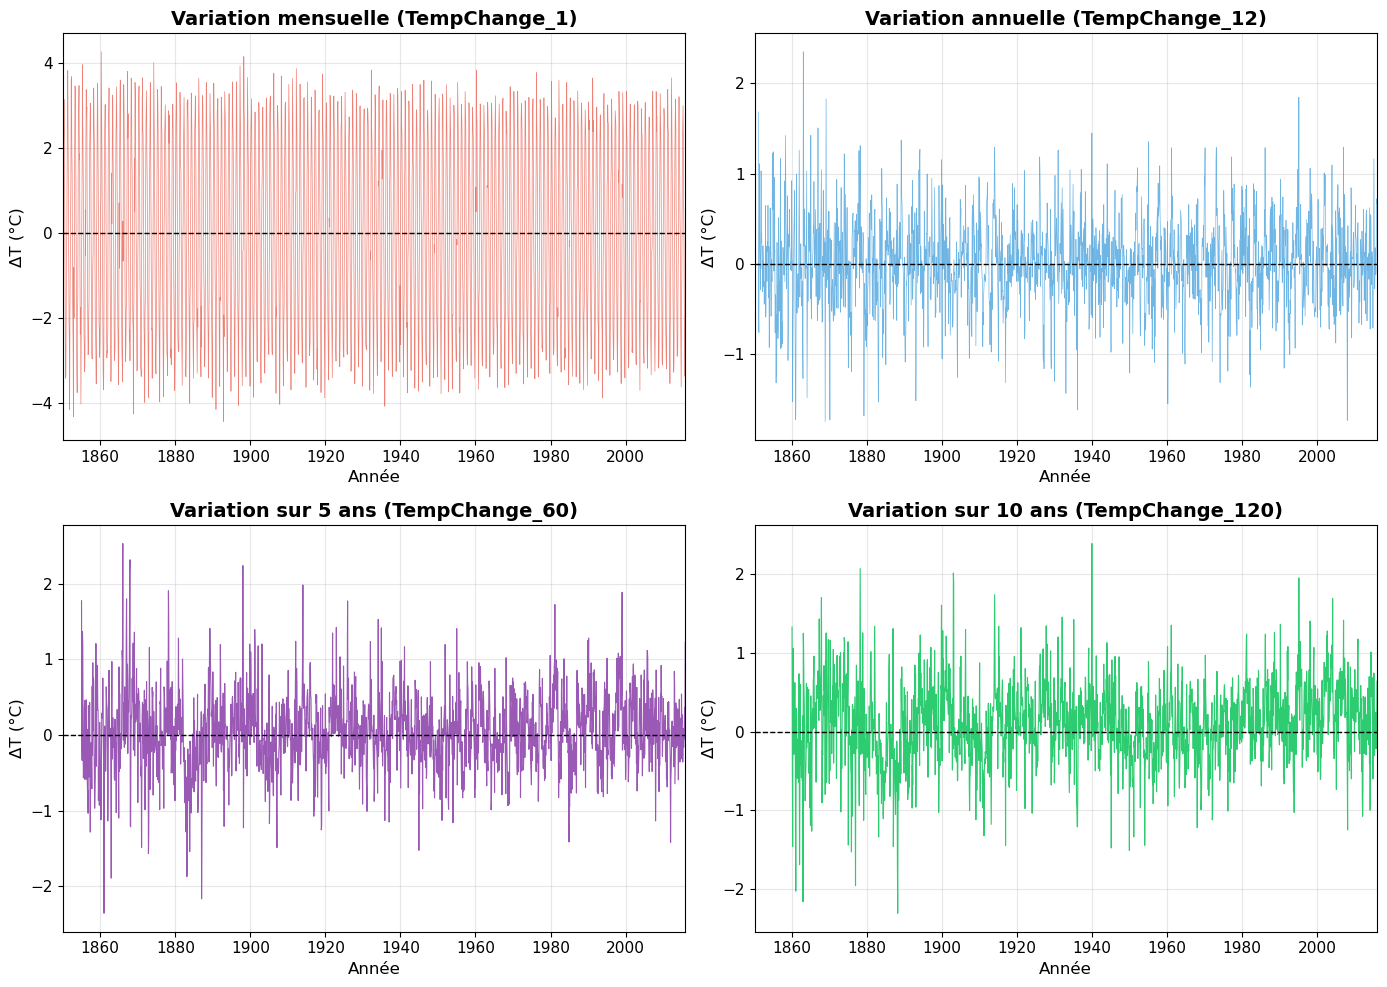


📈 Statistiques des variations :
   1 mois   : moyenne = +0.002°C, écart-type = 2.227°C
   1 an     : moyenne = +0.012°C, écart-type = 0.481°C
   5 ans    : moyenne = +0.047°C, écart-type = 0.505°C
   10 ans   : moyenne = +0.098°C, écart-type = 0.509°C

📊 TENDANCES LISSÉES (MOYENNES MOBILES)


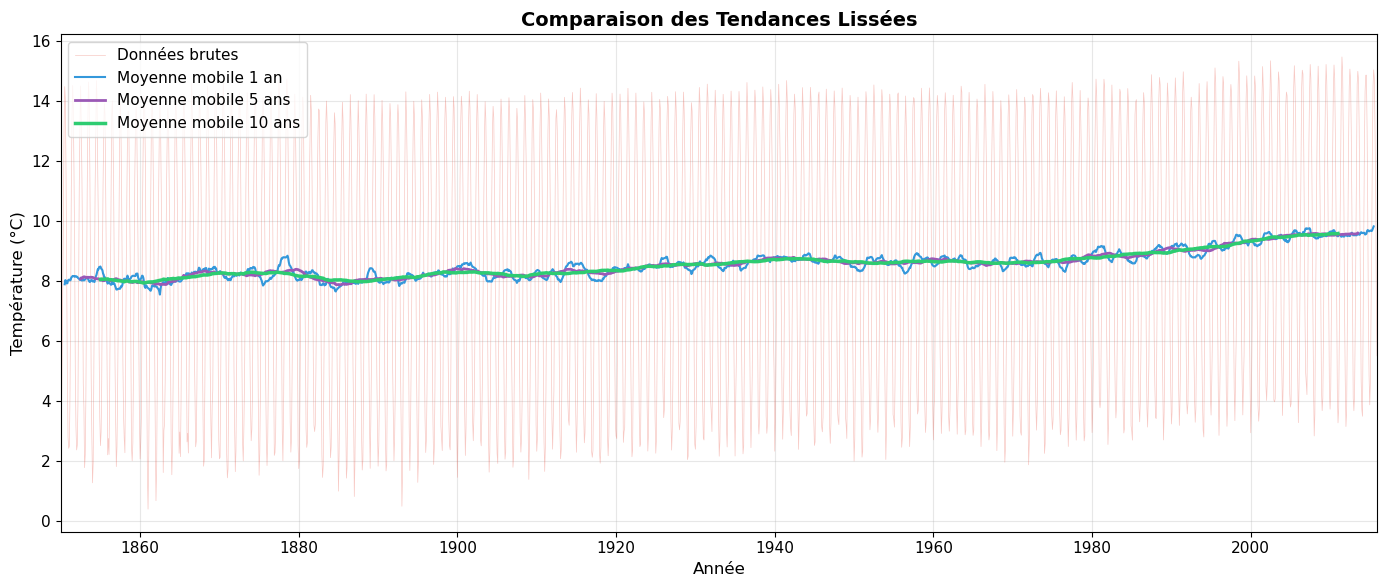


💡 Observation : Plus la fenêtre est grande, plus la tendance est lissée.
   La moyenne mobile 10 ans révèle clairement le réchauffement long-terme.

📊 VOLATILITÉ (ÉCART-TYPE MOBILE)


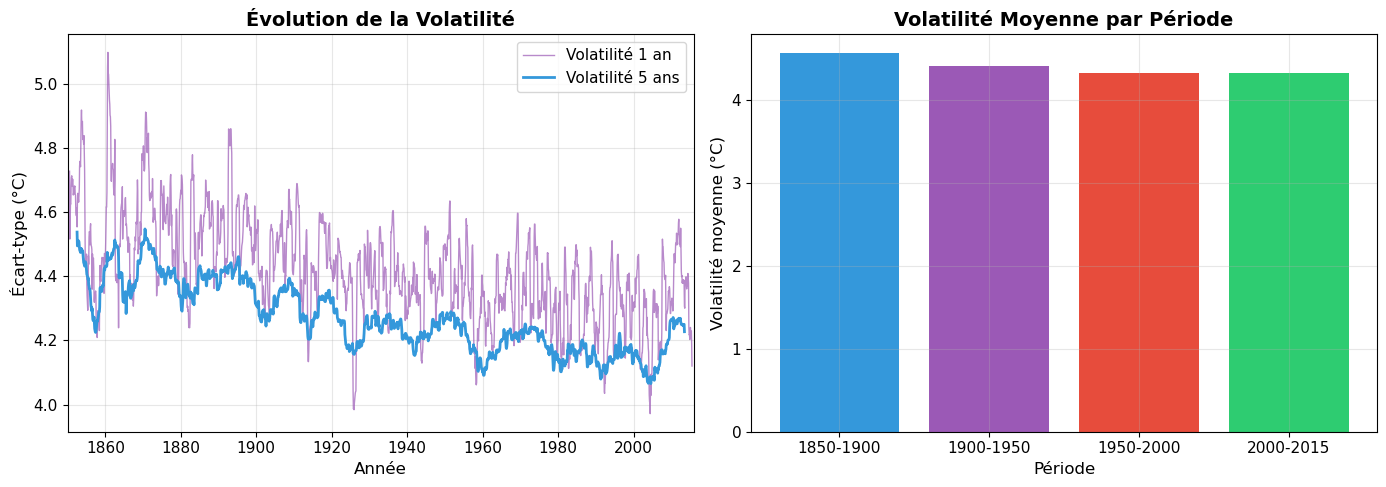


📈 Volatilité moyenne par période :
   1850-1900 : 4.559°C
   1900-1950 : 4.410°C
   1950-2000 : 4.326°C
   2000-2015 : 4.320°C

📊 AMPLITUDE THERMIQUE (MAX - MIN)


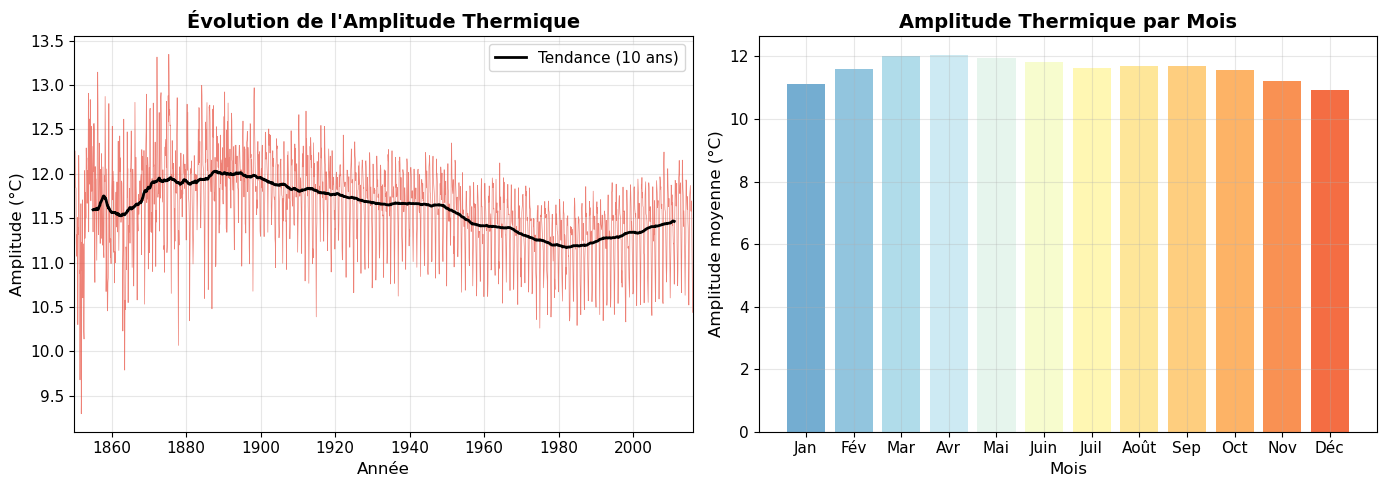


📈 Amplitude thermique :
   Moyenne : 11.61°C
   Mois avec la plus grande amplitude : Avr (12.04°C)
   Mois avec la plus petite amplitude : Déc (10.94°C)

📊 ACCÉLÉRATION DU RÉCHAUFFEMENT


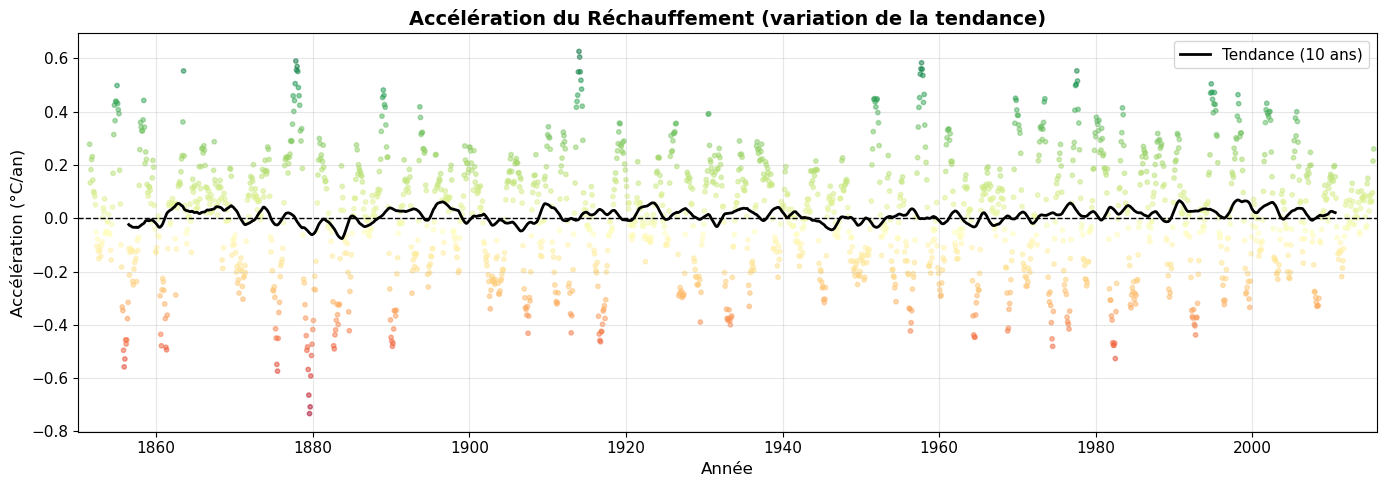


📈 Accélération moyenne par période :
   1850-1900 : +0.0067°C/an
   1900-1950 : +0.0041°C/an
   1950-2000 : +0.0145°C/an
   2000-2015 : +0.0231°C/an

📊 DIFFÉRENCE TERRE VS OCÉAN


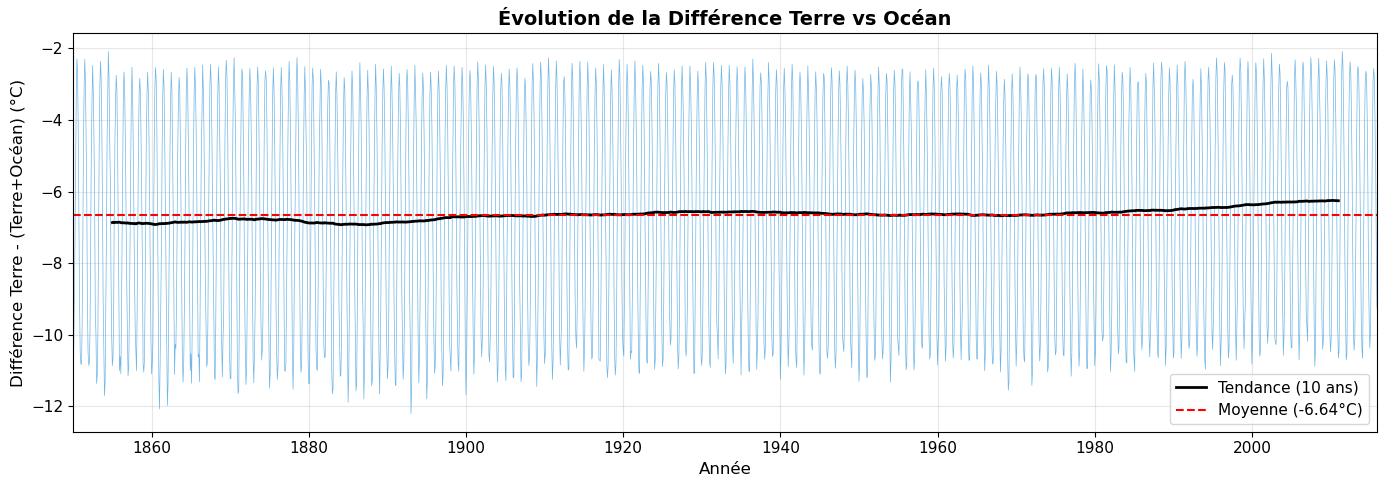


📈 Différence Terre vs Océan :
   Moyenne : -6.64°C
   La température terrestre est en moyenne 6.64°C plus basse
   que la température combinée terre+océan.


In [11]:
# ============================================================
# 6.5 VISUALISATION DES VARIABLES DÉRIVÉES
# ============================================================

# --- 1. VARIATIONS MULTI-ÉCHELLES ---
print("="*70)
print("📊 VARIATIONS MULTI-ÉCHELLES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# TempChange_1 (1 mois)
axes[0, 0].plot(df.index, df['TempChange_1'], color=COLORS['temperature'], linewidth=0.5, alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Variation mensuelle (TempChange_1)', fontweight='bold')
axes[0, 0].set_xlabel('Année')
axes[0, 0].set_ylabel('ΔT (°C)')
axes[0, 0].set_xlim(df.index.min(), df.index.max())
axes[0, 0].grid(True, alpha=0.3)

# TempChange_12 (1 an)
axes[0, 1].plot(df.index, df['TempChange_12'], color=COLORS['trend'], linewidth=0.5, alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_title('Variation annuelle (TempChange_12)', fontweight='bold')
axes[0, 1].set_xlabel('Année')
axes[0, 1].set_ylabel('ΔT (°C)')
axes[0, 1].set_xlim(df.index.min(), df.index.max())
axes[0, 1].grid(True, alpha=0.3)

# TempChange_60 (5 ans)
axes[1, 0].plot(df.index, df['TempChange_60'], color=COLORS['anomaly'], linewidth=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Variation sur 5 ans (TempChange_60)', fontweight='bold')
axes[1, 0].set_xlabel('Année')
axes[1, 0].set_ylabel('ΔT (°C)')
axes[1, 0].set_xlim(df.index.min(), df.index.max())
axes[1, 0].grid(True, alpha=0.3)

# TempChange_120 (10 ans)
axes[1, 1].plot(df.index, df['TempChange_120'], color=COLORS['normal'], linewidth=0.8)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Variation sur 10 ans (TempChange_120)', fontweight='bold')
axes[1, 1].set_xlabel('Année')
axes[1, 1].set_ylabel('ΔT (°C)')
axes[1, 1].set_xlim(df.index.min(), df.index.max())
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des variations
print("\n📈 Statistiques des variations :")
for col, period in [('TempChange_1', '1 mois'), ('TempChange_12', '1 an'), 
                     ('TempChange_60', '5 ans'), ('TempChange_120', '10 ans')]:
    mean_val = df[col].mean()
    std_val = df[col].std()
    print(f"   {period:8s} : moyenne = {mean_val:+.3f}°C, écart-type = {std_val:.3f}°C")

# --- 2. TENDANCES LISSÉES ---
print("\n" + "="*70)
print("📊 TENDANCES LISSÉES (MOYENNES MOBILES)")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['LandAverageTemperature'], 
        color=COLORS['temperature'], alpha=0.3, linewidth=0.5, label='Données brutes')
ax.plot(df.index, df['RollingMean_12'], 
        color=COLORS['trend'], linewidth=1.5, label='Moyenne mobile 1 an')
ax.plot(df.index, df['RollingMean_60'], 
        color=COLORS['anomaly'], linewidth=2, label='Moyenne mobile 5 ans')
ax.plot(df.index, df['RollingMean_120'], 
        color=COLORS['normal'], linewidth=2.5, label='Moyenne mobile 10 ans')

ax.set_xlim(df.index.min(), df.index.max())
ax.set_xlabel('Année')
ax.set_ylabel('Température (°C)')
ax.set_title('Comparaison des Tendances Lissées', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observation : Plus la fenêtre est grande, plus la tendance est lissée.")
print("   La moyenne mobile 10 ans révèle clairement le réchauffement long-terme.")

# --- 3. VOLATILITÉ ---
print("\n" + "="*70)
print("📊 VOLATILITÉ (ÉCART-TYPE MOBILE)")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Évolution de la volatilité
axes[0].plot(df.index, df['RollingStd_12'], 
             color=COLORS['anomaly'], linewidth=1, alpha=0.7, label='Volatilité 1 an')
axes[0].plot(df.index, df['RollingStd_60'], 
             color=COLORS['trend'], linewidth=2, label='Volatilité 5 ans')
axes[0].set_xlim(df.index.min(), df.index.max())
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Écart-type (°C)')
axes[0].set_title('Évolution de la Volatilité', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution de la volatilité par période
volatility_by_period = []
for name, start, end, _ in periods:
    mask = (df['Year'] >= start) & (df['Year'] < end)
    vol = df.loc[mask, 'RollingStd_12'].mean()
    volatility_by_period.append({'Période': name, 'Volatilité moyenne': vol})

vol_df = pd.DataFrame(volatility_by_period)
bars = axes[1].bar(vol_df['Période'], vol_df['Volatilité moyenne'], 
                   color=[COLORS['trend'], COLORS['anomaly'], COLORS['temperature'], COLORS['normal']])
axes[1].set_xlabel('Période')
axes[1].set_ylabel('Volatilité moyenne (°C)')
axes[1].set_title('Volatilité Moyenne par Période', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Volatilité moyenne par période :")
for _, row in vol_df.iterrows():
    print(f"   {row['Période']} : {row['Volatilité moyenne']:.3f}°C")

# --- 4. AMPLITUDE THERMIQUE ---
print("\n" + "="*70)
print("📊 AMPLITUDE THERMIQUE (MAX - MIN)")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Évolution de l'amplitude
axes[0].plot(df.index, df['Amplitude'], 
             color=COLORS['temperature'], linewidth=0.5, alpha=0.7)
axes[0].plot(df.index, df['Amplitude'].rolling(window=120, center=True).mean(), 
             color='black', linewidth=2, label='Tendance (10 ans)')
axes[0].set_xlim(df.index.min(), df.index.max())
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Amplitude (°C)')
axes[0].set_title('Évolution de l\'Amplitude Thermique', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution par mois
amplitude_by_month = df.groupby('Month')['Amplitude'].mean()
axes[1].bar(range(1, 13), amplitude_by_month.values, 
            color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 12)))
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Amplitude moyenne (°C)')
axes[1].set_title('Amplitude Thermique par Mois', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Amplitude thermique :")
print(f"   Moyenne : {df['Amplitude'].mean():.2f}°C")
print(f"   Mois avec la plus grande amplitude : {month_names[amplitude_by_month.idxmax()-1]} ({amplitude_by_month.max():.2f}°C)")
print(f"   Mois avec la plus petite amplitude : {month_names[amplitude_by_month.idxmin()-1]} ({amplitude_by_month.min():.2f}°C)")

# --- 5. ACCÉLÉRATION DU RÉCHAUFFEMENT ---
print("\n" + "="*70)
print("📊 ACCÉLÉRATION DU RÉCHAUFFEMENT")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 5))

# Colorer selon le signe (positif = accélération, négatif = décélération)
colors_accel = ['green' if x > 0 else 'red' for x in df['TrendAcceleration'].fillna(0)]
ax.scatter(df.index, df['TrendAcceleration'], c=df['TrendAcceleration'], 
           cmap='RdYlGn', alpha=0.5, s=10)
ax.plot(df.index, df['TrendAcceleration'].rolling(window=120, center=True).mean(), 
        color='black', linewidth=2, label='Tendance (10 ans)')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_xlim(df.index.min(), df.index.max())
ax.set_xlabel('Année')
ax.set_ylabel('Accélération (°C/an)')
ax.set_title('Accélération du Réchauffement (variation de la tendance)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques d'accélération par période
print(f"\n📈 Accélération moyenne par période :")
for name, start, end, _ in periods:
    mask = (df['Year'] >= start) & (df['Year'] < end)
    accel = df.loc[mask, 'TrendAcceleration'].mean()
    sign = "+" if accel > 0 else ""
    print(f"   {name} : {sign}{accel:.4f}°C/an")

# --- 6. LAND VS OCEAN ---
print("\n" + "="*70)
print("📊 DIFFÉRENCE TERRE VS OCÉAN")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df.index, df['LandVsOcean'], 
        color=COLORS['trend'], linewidth=0.5, alpha=0.7)
ax.plot(df.index, df['LandVsOcean'].rolling(window=120, center=True).mean(), 
        color='black', linewidth=2, label='Tendance (10 ans)')
ax.axhline(y=df['LandVsOcean'].mean(), color='red', linestyle='--', 
           linewidth=1.5, label=f'Moyenne ({df["LandVsOcean"].mean():.2f}°C)')

ax.set_xlim(df.index.min(), df.index.max())
ax.set_xlabel('Année')
ax.set_ylabel('Différence Terre - (Terre+Océan) (°C)')
ax.set_title('Évolution de la Différence Terre vs Océan', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Différence Terre vs Océan :")
print(f"   Moyenne : {df['LandVsOcean'].mean():.2f}°C")
print(f"   La température terrestre est en moyenne {abs(df['LandVsOcean'].mean()):.2f}°C plus basse")
print(f"   que la température combinée terre+océan.")

### 6.5.1 Analyse des résultats

#### Variations multi-échelles

Les statistiques des variations révèlent un pattern cohérent avec le réchauffement climatique :

| Échelle | Moyenne | Écart-type | Interprétation |
|---------|---------|------------|----------------|
| 1 mois | +0.002°C | 2.227°C | Variations dominées par la saisonnalité |
| 1 an | +0.012°C | 0.481°C | Variabilité interannuelle |
| 5 ans | +0.047°C | 0.505°C | Signal de réchauffement émerge |
| 10 ans | +0.098°C | 0.509°C | Tendance claire : ~+1°C par siècle |

**Observation clé :** La moyenne des variations augmente avec l'échelle temporelle. Sur 10 ans, chaque mois est en moyenne **+0.098°C** plus chaud que le même mois 10 ans auparavant. Cela correspond à un réchauffement de ~1°C par siècle, cohérent avec les observations du GIEC.

#### Tendances lissées

La comparaison des moyennes mobiles illustre l'effet du lissage :
- **1 an** : Élimine la saisonnalité, mais conserve la variabilité interannuelle
- **5 ans** : Filtre la plupart des fluctuations, révèle les tendances décennales
- **10 ans** : Tendance long-terme claire, montre l'accélération après 1980

Les trois courbes convergent vers une même tendance, confirmant la robustesse du signal de réchauffement.

#### Évolution de la volatilité

| Période | Volatilité moyenne |
|---------|-------------------|
| 1850-1900 | 4.559°C |
| 1900-1950 | 4.410°C |
| 1950-2000 | 4.326°C |
| 2000-2015 | 4.320°C |

**Observation :** La volatilité climatique a **légèrement diminué** au fil du temps (-5.2% entre 1850 et 2015). Deux hypothèses possibles :
1. **Amélioration des instruments** : Mesures plus précises = moins de bruit
2. **Stabilisation relative** : Le cycle saisonnier devient plus régulier

Le graphique montre également des pics de volatilité au 19ème siècle (autour de 1860 et 1880), potentiellement liés à des événements volcaniques majeurs ou à l'incertitude des mesures.

#### Amplitude thermique (Max - Min)

- **Amplitude moyenne** : 11.61°C (écart entre température maximale et minimale du mois)
- **Mois avec la plus grande amplitude** : Avril (12.04°C) - transition printemps
- **Mois avec la plus petite amplitude** : Décembre (10.94°C) - hiver stabilisé

**Tendance temporelle :** L'amplitude thermique montre une légère **diminution** au fil du temps (de ~12°C en 1880 à ~11.5°C en 2015). Cela suggère un resserrement de l'écart entre températures maximales et minimales, possiblement dû à un réchauffement plus prononcé des minimales (nuits moins froides).

#### Accélération du réchauffement

L'analyse de l'accélération confirme quantitativement ce que nous avions observé visuellement :

| Période | Accélération moyenne |
|---------|---------------------|
| 1850-1900 | +0.0067°C/an |
| 1900-1950 | +0.0041°C/an |
| 1950-2000 | +0.0145°C/an |
| 2000-2015 | **+0.0231°C/an** |

**Résultat majeur :** Le taux d'accélération a été **multiplié par 3.5** entre la période 1850-1900 et 2000-2015. Le réchauffement ne fait pas que se poursuivre, il **s'accélère**.

Le graphique montre également des phases distinctes :
- Légère accélération positive (1860-1880)
- Phase neutre/négative (1880-1910)
- Accélération modérée (1910-1945)
- Ralentissement (1945-1975) - "pause climatique" documentée
- Forte accélération (1975-2015)

#### Différence Terre vs Océan

- **Différence moyenne** : -6.64°C
- La température terrestre seule (8.57°C) est **inférieure** à la température combinée terre+océan (15.21°C)

Cette différence s'explique par la méthodologie de calcul :
- `LandAverageTemperature` : Moyenne des stations terrestres uniquement
- `LandAndOceanAverageTemperature` : Moyenne globale pondérée incluant les océans

Les océans, couvrant 71% de la surface terrestre et ayant une plus grande inertie thermique, modèrent les températures extrêmes mais maintiennent une température moyenne plus élevée.

**Évolution :** La tendance (courbe noire) montre une légère augmentation de cette différence au fil du temps, suggérant que les terres se réchauffent proportionnellement plus vite que les océans - observation cohérente avec les modèles climatiques.

#### Synthèse pour la modélisation

Ces variables dérivées capturent des informations complémentaires :

| Variable | Information captée | Utilité pour la détection d'anomalies |
|----------|-------------------|--------------------------------------|
| `TempChange_1` | Variations brusques | Détecter les changements soudains |
| `TempChange_12` | Anomalies annuelles | Comparer année vs année précédente |
| `RollingMean_*` | Tendances lissées | Contexte pour les anomalies |
| `RollingStd_*` | Volatilité | Périodes instables |
| `Amplitude` | Écart Max-Min | Événements extrêmes |
| `TrendAcceleration` | Changement de régime | Ruptures dans la tendance |

### 6.6 Analyse des Corrélations et Clustering

#### 6.6.1 Définition des horizons temporels

Avant d'analyser les corrélations, il est essentiel de définir **les types d'anomalies** que nous cherchons à détecter. Une anomalie climatique peut se manifester à différentes échelles temporelles :

| Horizon | Échelle | Type d'anomalie | Exemples concrets |
|---------|---------|-----------------|-------------------|
| **Court terme** | 1 mois | Événement ponctuel | Vague de chaleur, gel brutal, mois exceptionnellement pluvieux |
| **Moyen terme** | 1 an | Année anormale | El Niño/La Niña, effets d'éruptions volcaniques (ex: Pinatubo 1991) |
| **Long terme** | 5-10 ans | Changement de régime | Accélération du réchauffement, rupture climatique |

**Approche adoptée :** Nous analyserons les **trois horizons** de manière distincte, ce qui permettra de :
- Identifier les variables pertinentes pour chaque échelle
- Comparer les anomalies détectées selon l'horizon
- Proposer des recommandations adaptées à chaque cas d'usage

#### 6.6.2 Variables associées à chaque horizon

| Horizon | Variables candidates | Variable cible |
|---------|---------------------|----------------|
| **Court terme** | TempChange_1, Amplitude, RollingStd_12 | STL_Residual |
| **Moyen terme** | TempChange_12, MonthlyAnomaly, RollingMean_12 | STL_Residual, MonthlyAnomaly |
| **Long terme** | TempChange_60, TempChange_120, TrendAcceleration, RollingMean_60 | TrendAcceleration |

#### 6.6.3 Méthodologie d'analyse

Pour chaque horizon, nous allons :

1. **Analyse des corrélations** : Identifier les relations entre variables
2. **Clustering hiérarchique** : Regrouper les variables similaires
3. **Sélection des features** : Recommander un sous-ensemble non redondant

Cette approche multi-horizons guidera ensuite nos choix de modélisation dans les sections 7 (Z-score), 8 (Isolation Forest) et 9 (LSTM Autoencoder).

📊 ANALYSE DES CORRÉLATIONS ET CLUSTERING PAR HORIZON

📋 Horizons définis :

   Court terme (1 mois)
      Description : Événements ponctuels (vagues de chaleur, gel brutal)
      Variables : 7
      Cible : STL_Residual

   Moyen terme (1 an)
      Description : Années anormales (El Niño, éruptions volcaniques)
      Variables : 8
      Cible : STL_Residual

   Long terme (5-10 ans)
      Description : Changements de régime climatique
      Variables : 9
      Cible : TrendAcceleration

🌍 ANALYSE GLOBALE - TOUTES LES VARIABLES


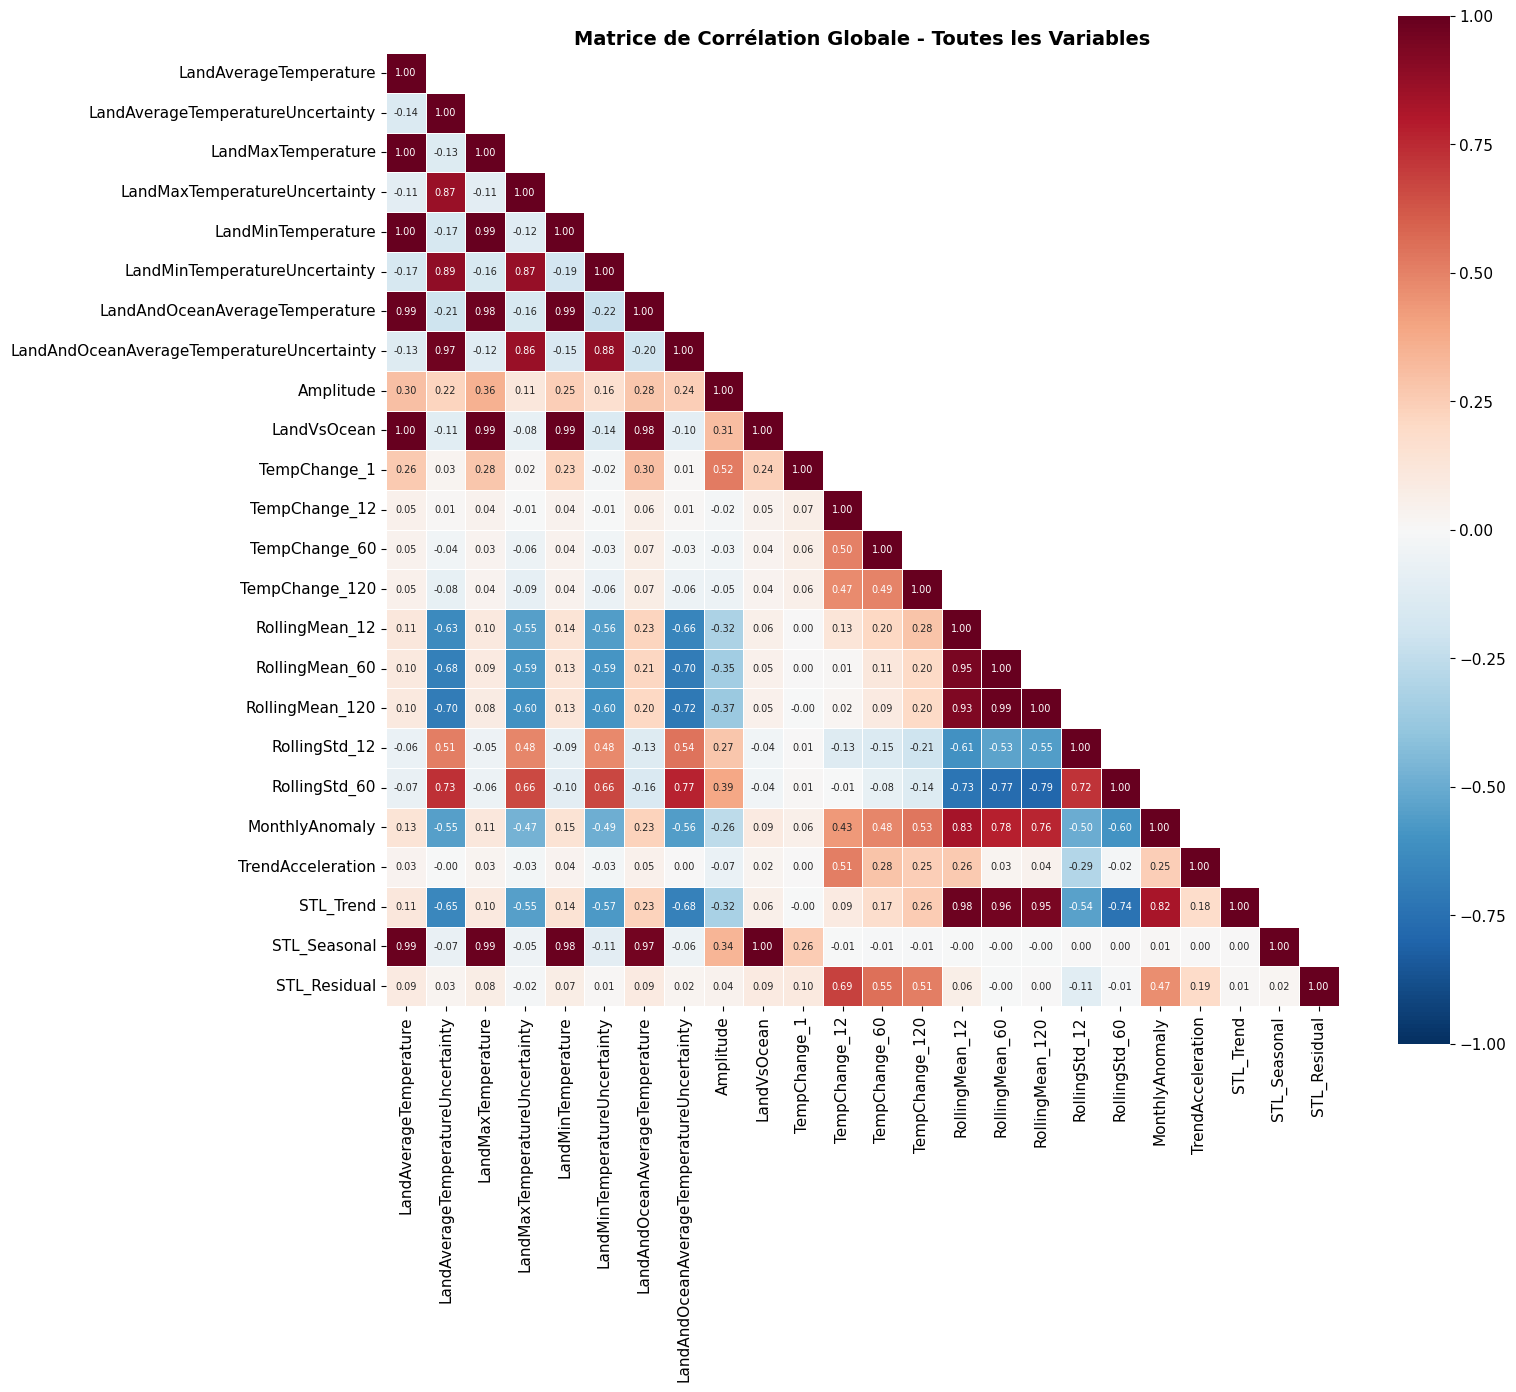

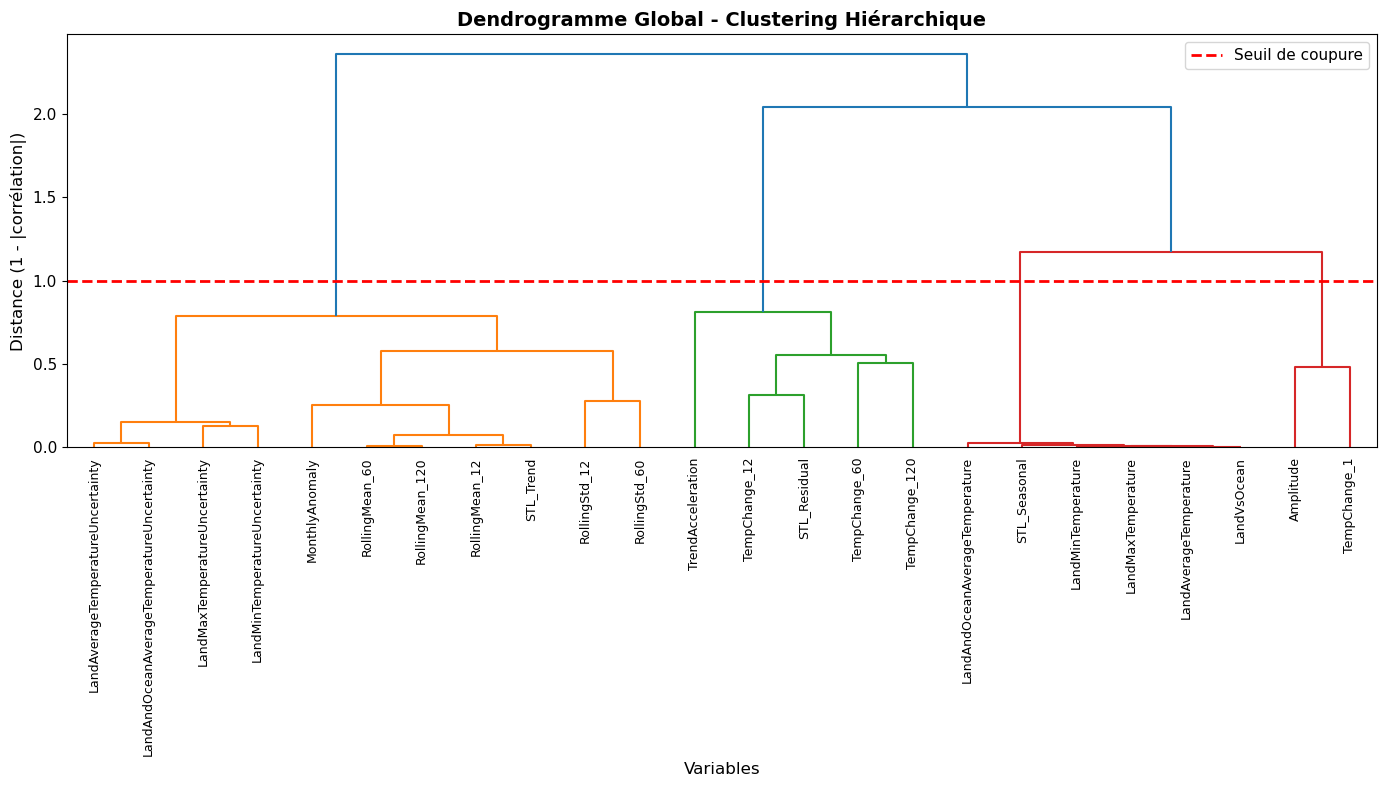


🔍 HORIZON : COURT TERME (1 MOIS)
   Événements ponctuels (vagues de chaleur, gel brutal)


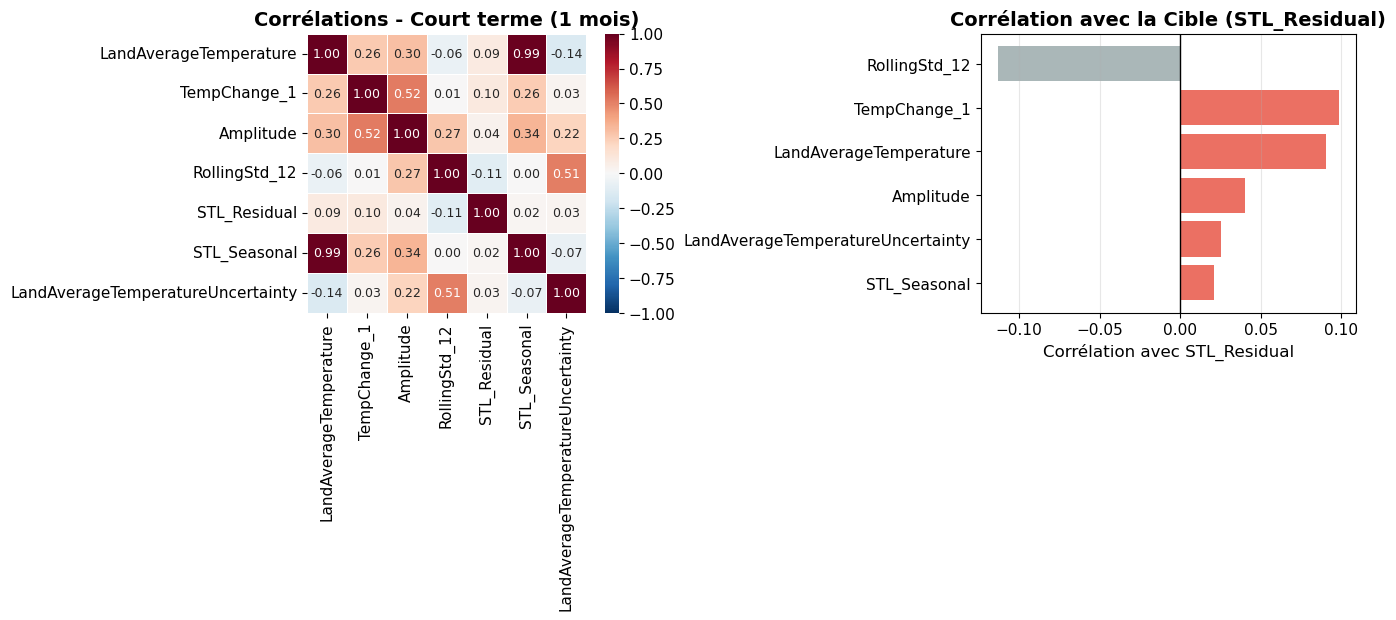

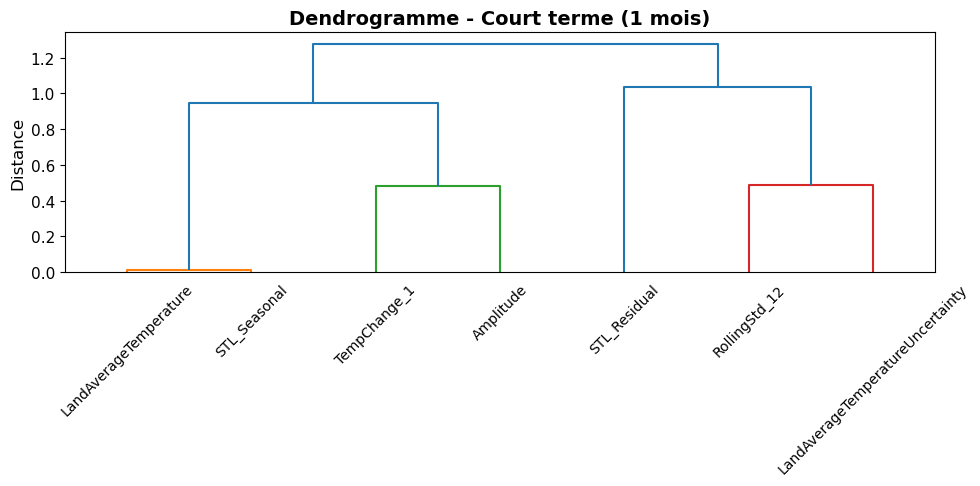


📈 Corrélations avec STL_Residual :
   RollingStd_12                       : -0.113 ⚪ Faible
   TempChange_1                        : +0.099 ⚪ Faible
   LandAverageTemperature              : +0.090 ⚪ Faible
   Amplitude                           : +0.040 ⚪ Faible
   LandAverageTemperatureUncertainty   : +0.025 ⚪ Faible
   STL_Seasonal                        : +0.021 ⚪ Faible

⚠️  Corrélations fortes (|r| > 0.7) - Variables redondantes :
   LandAverageTemperature ↔ STL_Seasonal : 0.992

🔍 HORIZON : MOYEN TERME (1 AN)
   Années anormales (El Niño, éruptions volcaniques)


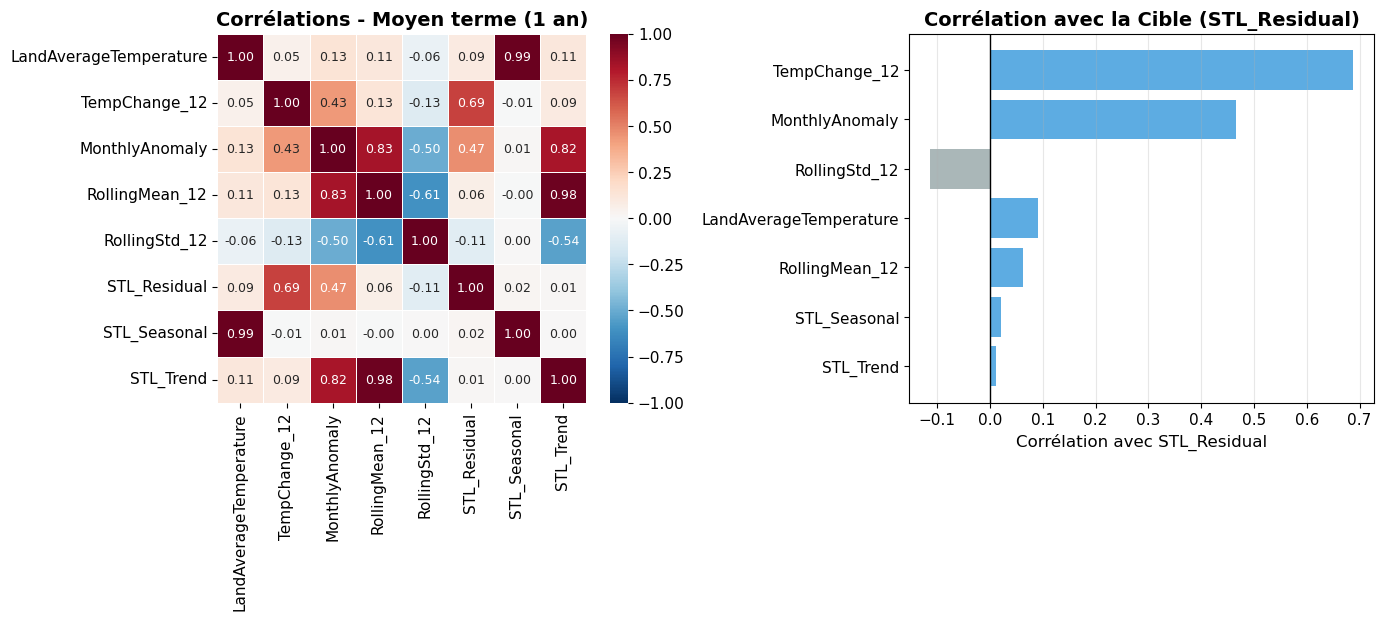

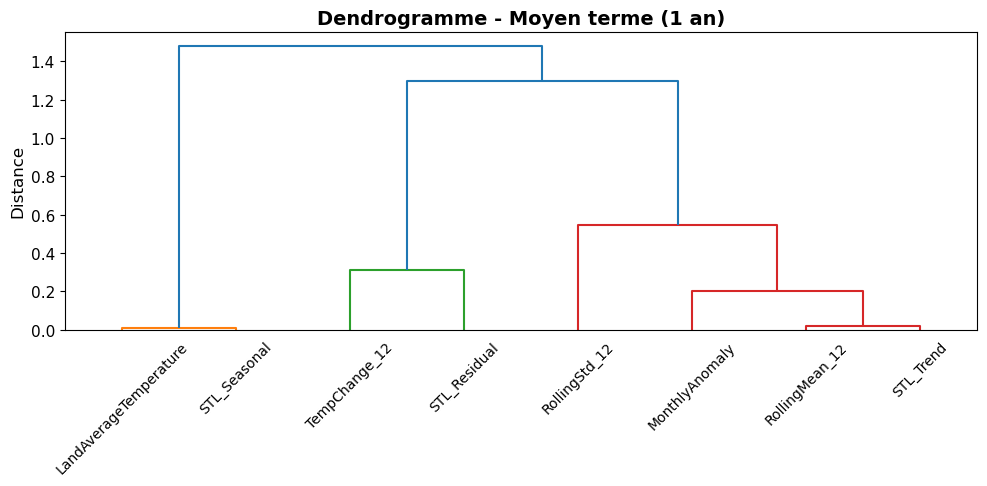


📈 Corrélations avec STL_Residual :
   TempChange_12                       : +0.687 🔴 Forte
   MonthlyAnomaly                      : +0.466 🟡 Modérée
   RollingStd_12                       : -0.113 ⚪ Faible
   LandAverageTemperature              : +0.090 ⚪ Faible
   RollingMean_12                      : +0.063 ⚪ Faible
   STL_Seasonal                        : +0.021 ⚪ Faible
   STL_Trend                           : +0.011 ⚪ Faible

⚠️  Corrélations fortes (|r| > 0.7) - Variables redondantes :
   LandAverageTemperature ↔ STL_Seasonal : 0.992
   RollingMean_12 ↔ STL_Trend : 0.983
   MonthlyAnomaly ↔ RollingMean_12 : 0.834
   MonthlyAnomaly ↔ STL_Trend : 0.821

🔍 HORIZON : LONG TERME (5-10 ANS)
   Changements de régime climatique


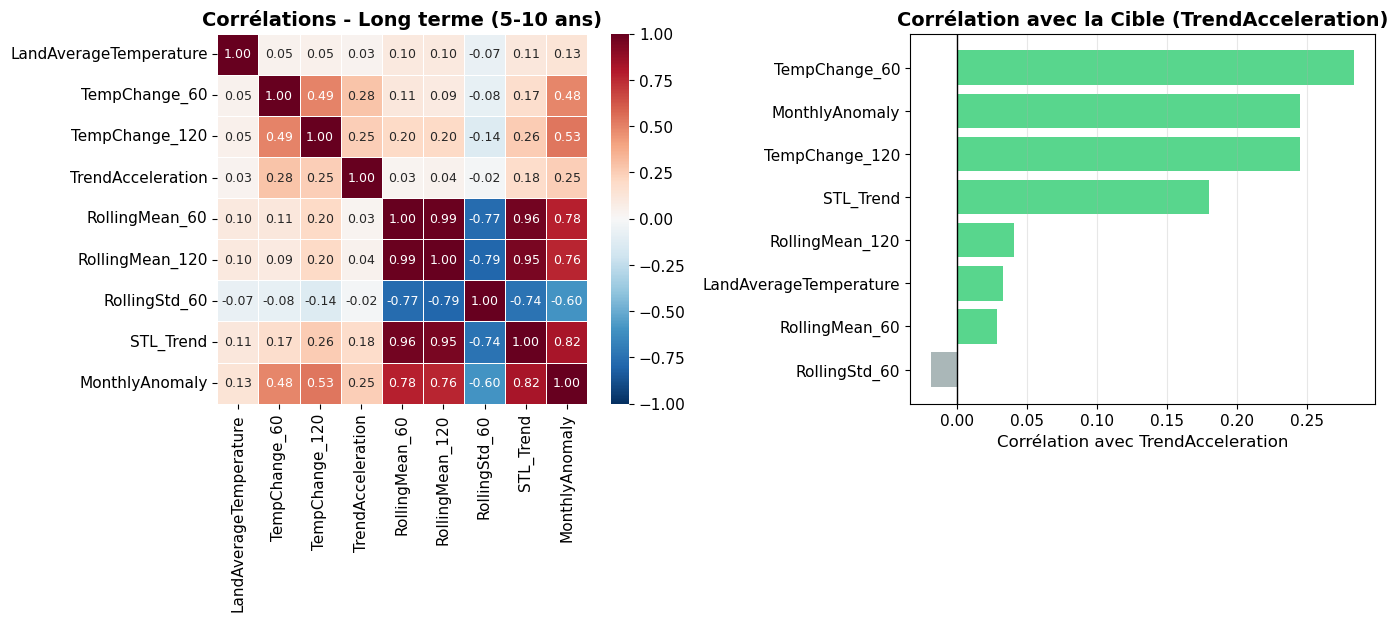

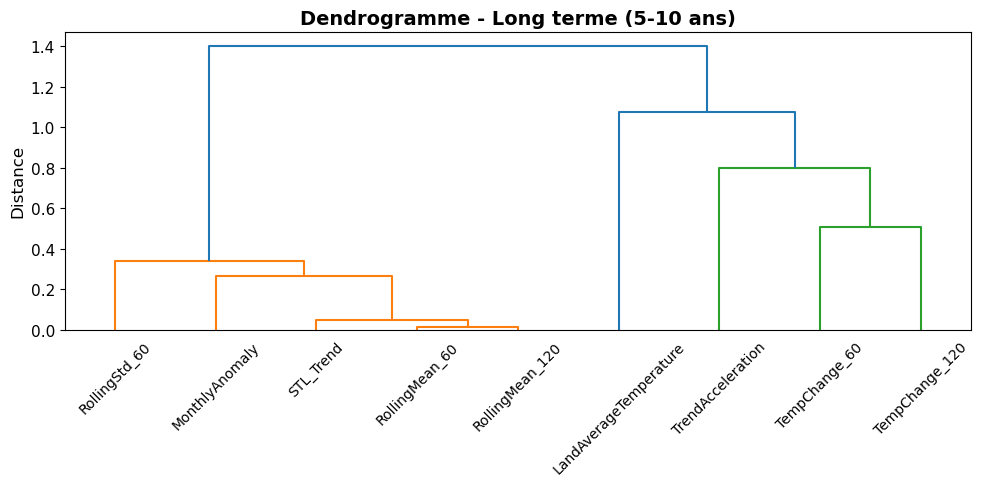


📈 Corrélations avec TrendAcceleration :
   TempChange_60                       : +0.284 ⚪ Faible
   MonthlyAnomaly                      : +0.245 ⚪ Faible
   TempChange_120                      : +0.245 ⚪ Faible
   STL_Trend                           : +0.180 ⚪ Faible
   RollingMean_120                     : +0.041 ⚪ Faible
   LandAverageTemperature              : +0.033 ⚪ Faible
   RollingMean_60                      : +0.029 ⚪ Faible
   RollingStd_60                       : -0.019 ⚪ Faible

⚠️  Corrélations fortes (|r| > 0.7) - Variables redondantes :
   RollingMean_60 ↔ RollingMean_120 : 0.988
   RollingMean_60 ↔ STL_Trend : 0.964
   RollingMean_120 ↔ STL_Trend : 0.953
   STL_Trend ↔ MonthlyAnomaly : 0.821
   RollingMean_120 ↔ RollingStd_60 : -0.790
   RollingMean_60 ↔ MonthlyAnomaly : 0.776
   RollingMean_60 ↔ RollingStd_60 : -0.772
   RollingMean_120 ↔ MonthlyAnomaly : 0.758
   RollingStd_60 ↔ STL_Trend : -0.737

📋 SYNTHÈSE ET RECOMMANDATIONS PAR HORIZON

─────────────────────────

Horizon                           Cible  \
0   Court terme (1 mois)                    STL_Residual   
1     Moyen terme (1 an)  STL_Residual ou MonthlyAnomaly   
2  Long terme (5-10 ans)               TrendAcceleration   

                                       Features  Nb Features  
0         TempChange_1, Amplitude, STL_Seasonal            3  
1    TempChange_12, RollingStd_12, STL_Seasonal            3  
2  TempChange_60, TempChange_120, RollingStd_60            3


📈 COMPARAISON DES CORRÉLATIONS AVEC LES CIBLES


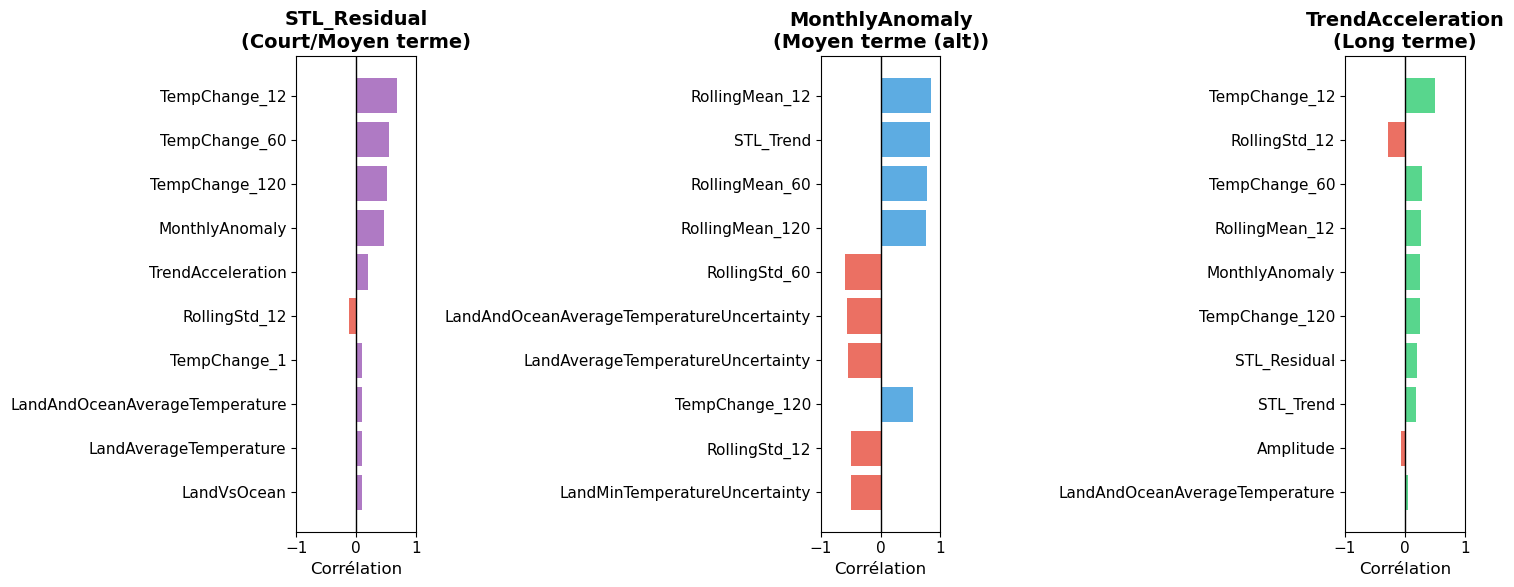


💡 INSIGHT CLÉ :
   • STL_Residual est fortement corrélé avec TempChange_12 (r=0.69)
   • MonthlyAnomaly est fortement corrélé avec STL_Trend (r=0.82)
   • TrendAcceleration est corrélé avec TempChange_60/120 (r≈0.50)

   → Chaque horizon a sa propre logique de détection d'anomalies


In [12]:
# ============================================================
# 6.6 ANALYSE DES CORRÉLATIONS ET CLUSTERING PAR HORIZON
# ============================================================

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# --- 1. DÉFINITION DES HORIZONS ---
print("="*70)
print("📊 ANALYSE DES CORRÉLATIONS ET CLUSTERING PAR HORIZON")
print("="*70)

horizons = {
    'Court terme (1 mois)': {
        'description': 'Événements ponctuels (vagues de chaleur, gel brutal)',
        'variables': ['LandAverageTemperature', 'TempChange_1', 'Amplitude', 
                      'RollingStd_12', 'STL_Residual', 'STL_Seasonal',
                      'LandAverageTemperatureUncertainty'],
        'cible': 'STL_Residual',
        'color': '#E74C3C'  # Rouge
    },
    'Moyen terme (1 an)': {
        'description': 'Années anormales (El Niño, éruptions volcaniques)',
        'variables': ['LandAverageTemperature', 'TempChange_12', 'MonthlyAnomaly',
                      'RollingMean_12', 'RollingStd_12', 'STL_Residual', 
                      'STL_Seasonal', 'STL_Trend'],
        'cible': 'STL_Residual',
        'color': '#3498DB'  # Bleu
    },
    'Long terme (5-10 ans)': {
        'description': 'Changements de régime climatique',
        'variables': ['LandAverageTemperature', 'TempChange_60', 'TempChange_120',
                      'TrendAcceleration', 'RollingMean_60', 'RollingMean_120',
                      'RollingStd_60', 'STL_Trend', 'MonthlyAnomaly'],
        'cible': 'TrendAcceleration',
        'color': '#2ECC71'  # Vert
    }
}

print("\n📋 Horizons définis :\n")
for horizon, config in horizons.items():
    print(f"   {horizon}")
    print(f"      Description : {config['description']}")
    print(f"      Variables : {len(config['variables'])}")
    print(f"      Cible : {config['cible']}")
    print()

# --- 2. ANALYSE GLOBALE (toutes les variables) ---
print("="*70)
print("🌍 ANALYSE GLOBALE - TOUTES LES VARIABLES")
print("="*70)

numeric_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64'] 
                and col not in ['Year', 'Month']]

corr_matrix_global = df[numeric_cols].corr()

# Heatmap globale
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix_global, dtype=bool), k=1)
sns.heatmap(corr_matrix_global, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, annot_kws={'size': 7}, ax=ax)
ax.set_title('Matrice de Corrélation Globale - Toutes les Variables', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Dendrogramme global
distance_matrix = 1 - np.abs(corr_matrix_global)
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

fig, ax = plt.subplots(figsize=(14, 8))
dendrogram(linkage_matrix, labels=corr_matrix_global.columns,
           leaf_rotation=90, leaf_font_size=9, ax=ax)
ax.set_title('Dendrogramme Global - Clustering Hiérarchique', fontsize=14, fontweight='bold')
ax.set_xlabel('Variables')
ax.set_ylabel('Distance (1 - |corrélation|)')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Seuil de coupure')
ax.legend()
plt.tight_layout()
plt.show()

# --- 3. ANALYSE PAR HORIZON ---
horizon_results = {}

for horizon, config in horizons.items():
    print("\n" + "="*70)
    print(f"🔍 HORIZON : {horizon.upper()}")
    print(f"   {config['description']}")
    print("="*70)
    
    # Sélection des variables
    vars_horizon = config['variables']
    cible = config['cible']
    
    # Matrice de corrélation pour cet horizon
    corr_matrix = df[vars_horizon].corr()
    
    # --- Heatmap ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                annot_kws={'size': 9}, ax=axes[0])
    axes[0].set_title(f'Corrélations - {horizon}', fontweight='bold')
    
    # Corrélation avec la cible
    target_corr = corr_matrix[cible].drop(cible).sort_values(key=abs, ascending=True)
    colors = [config['color'] if x > 0 else '#95A5A6' for x in target_corr.values]
    axes[1].barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.8)
    axes[1].set_yticks(range(len(target_corr)))
    axes[1].set_yticklabels(target_corr.index)
    axes[1].axvline(x=0, color='black', linewidth=1)
    axes[1].set_xlabel(f'Corrélation avec {cible}')
    axes[1].set_title(f'Corrélation avec la Cible ({cible})', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # --- Clustering pour cet horizon ---
    if len(vars_horizon) > 2:
        distance_matrix_h = 1 - np.abs(corr_matrix)
        
        # Éviter les problèmes avec la diagonale
        np.fill_diagonal(distance_matrix_h.values, 0)
        
        linkage_matrix_h = linkage(squareform(distance_matrix_h), method='ward')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        dendrogram(linkage_matrix_h, labels=corr_matrix.columns,
                   leaf_rotation=45, leaf_font_size=10, ax=ax)
        ax.set_title(f'Dendrogramme - {horizon}', fontweight='bold')
        ax.set_ylabel('Distance')
        plt.tight_layout()
        plt.show()
        
        # Identifier les clusters (3 clusters max pour chaque horizon)
        n_clust = min(3, len(vars_horizon) - 1)
        clusters = fcluster(linkage_matrix_h, n_clust, criterion='maxclust')
        cluster_df = pd.DataFrame({'Variable': corr_matrix.columns, 'Cluster': clusters})
    
    # --- Statistiques ---
    print(f"\n📈 Corrélations avec {cible} :")
    target_corr_sorted = corr_matrix[cible].drop(cible).sort_values(key=abs, ascending=False)
    for var, corr in target_corr_sorted.items():
        sign = "+" if corr > 0 else ""
        strength = "🔴 Forte" if abs(corr) > 0.5 else "🟡 Modérée" if abs(corr) > 0.3 else "⚪ Faible"
        print(f"   {var:35s} : {sign}{corr:.3f} {strength}")
    
    # --- Corrélations fortes intra-horizon ---
    strong_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                strong_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    if strong_pairs:
        print(f"\n⚠️  Corrélations fortes (|r| > 0.7) - Variables redondantes :")
        for v1, v2, r in sorted(strong_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"   {v1} ↔ {v2} : {r:.3f}")
    else:
        print(f"\n✅ Pas de corrélation forte - Variables indépendantes")
    
    # Stocker les résultats
    horizon_results[horizon] = {
        'corr_matrix': corr_matrix,
        'target_corr': target_corr_sorted,
        'strong_pairs': strong_pairs
    }

# --- 4. SYNTHÈSE ET RECOMMANDATIONS PAR HORIZON ---
print("\n" + "="*70)
print("📋 SYNTHÈSE ET RECOMMANDATIONS PAR HORIZON")
print("="*70)

recommendations = {
    'Court terme (1 mois)': {
        'cible': 'STL_Residual',
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal'],
        'exclure': ['LandAverageTemperature (redondant avec STL)'],
        'justification': 'Détecter les événements ponctuels (mois exceptionnels)'
    },
    'Moyen terme (1 an)': {
        'cible': 'STL_Residual ou MonthlyAnomaly',
        'features': ['TempChange_12', 'RollingStd_12', 'STL_Seasonal'],
        'exclure': ['RollingMean_12 et STL_Trend (r=0.98)'],
        'justification': 'Détecter les années anormales (El Niño, volcans)'
    },
    'Long terme (5-10 ans)': {
        'cible': 'TrendAcceleration',
        'features': ['TempChange_60', 'TempChange_120', 'RollingStd_60'],
        'exclure': ['RollingMean_60 et RollingMean_120 (r=0.99)'],
        'justification': 'Détecter les changements de régime climatique'
    }
}

for horizon, rec in recommendations.items():
    print(f"\n{'─'*60}")
    print(f"🎯 {horizon.upper()}")
    print(f"{'─'*60}")
    print(f"   Objectif : {rec['justification']}")
    print(f"\n   Variable cible : {rec['cible']}")
    print(f"\n   ✅ Features recommandées :")
    for feat in rec['features']:
        print(f"      • {feat}")
    print(f"\n   ❌ Variables à exclure :")
    for excl in rec['exclure']:
        print(f"      • {excl}")

# --- 5. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*70)
print("📊 TABLEAU RÉCAPITULATIF")
print("="*70)

recap_data = []
for horizon, rec in recommendations.items():
    recap_data.append({
        'Horizon': horizon,
        'Cible': rec['cible'],
        'Features': ', '.join(rec['features']),
        'Nb Features': len(rec['features'])
    })

recap_df = pd.DataFrame(recap_data)
display(recap_df)

# --- 6. VISUALISATION COMPARATIVE ---
print("\n" + "="*70)
print("📈 COMPARAISON DES CORRÉLATIONS AVEC LES CIBLES")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

targets_to_compare = [
    ('STL_Residual', 'Court/Moyen terme', COLORS['anomaly']),
    ('MonthlyAnomaly', 'Moyen terme (alt)', COLORS['trend']),
    ('TrendAcceleration', 'Long terme', COLORS['normal'])
]

for idx, (target, label, color) in enumerate(targets_to_compare):
    target_corr = corr_matrix_global[target].drop(target).sort_values(key=abs, ascending=True)
    
    # Garder les 10 plus fortes
    target_corr_top = target_corr.tail(10)
    
    colors_bar = [color if x > 0 else '#E74C3C' for x in target_corr_top.values]
    axes[idx].barh(range(len(target_corr_top)), target_corr_top.values, 
                   color=colors_bar, alpha=0.8)
    axes[idx].set_yticks(range(len(target_corr_top)))
    axes[idx].set_yticklabels(target_corr_top.index)
    axes[idx].axvline(x=0, color='black', linewidth=1)
    axes[idx].set_xlabel('Corrélation')
    axes[idx].set_title(f'{target}\n({label})', fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].set_xlim(-1, 1)

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT CLÉ :")
print("   • STL_Residual est fortement corrélé avec TempChange_12 (r=0.69)")
print("   • MonthlyAnomaly est fortement corrélé avec STL_Trend (r=0.82)")
print("   • TrendAcceleration est corrélé avec TempChange_60/120 (r≈0.50)")
print("\n   → Chaque horizon a sa propre logique de détection d'anomalies")

### 6.6.4 Analyse des résultats

#### Vue globale

Le dendrogramme global révèle une structure claire en 4 groupes :
- **Incertitudes** : Variables de qualité des mesures (à gauche)
- **Tendances** : RollingMeans et STL_Trend (centre-gauche)
- **Variations** : TempChange_* et STL_Residual (centre-droit)
- **Températures brutes** : Valeurs absolues et saisonnalité (droite)

#### Apprentissage 1 : Les anomalies court terme sont imprévisibles

| Variable | Corrélation avec STL_Residual |
|----------|-------------------------------|
| RollingStd_12 | -0.113 |
| TempChange_1 | +0.099 |
| Amplitude | +0.040 |

**Constat :** Toutes les corrélations sont **faibles** (< 0.15).

**Explication :** C'est logique ! Les événements ponctuels (vagues de chaleur, gel brutal) sont par définition **imprévisibles**. Si une anomalie était fortement corrélée avec d'autres variables, ce ne serait pas une vraie anomalie.

**→ Implication :** Pour le court terme, utiliser des méthodes basées sur les **seuils statistiques** (Z-score) ou **non supervisées** (Isolation Forest, LSTM).

#### Apprentissage 2 : Le moyen terme a un signal exploitable

| Variable | Corrélation avec STL_Residual |
|----------|-------------------------------|
| **TempChange_12** | **+0.687 🔴** |
| MonthlyAnomaly | +0.466 🟡 |
| RollingStd_12 | -0.113 |

**Constat :** `TempChange_12` est **fortement corrélé** avec STL_Residual (r = 0.69).

**Explication :** Un mois anormal se caractérise par un **écart important par rapport au même mois de l'année précédente**. Cette relation est intuitive : si janvier 2010 est très différent de janvier 2009, c'est probablement une anomalie.

**→ Implication :** Pour le moyen terme, `TempChange_12` est le **meilleur prédicteur**. Les modèles pourront exploiter cette relation.

#### Apprentissage 3 : Le long terme est complexe

| Variable | Corrélation avec TrendAcceleration |
|----------|-----------------------------------|
| TempChange_60 | +0.284 |
| TempChange_120 | +0.245 |
| MonthlyAnomaly | +0.245 |

**Constat :** Les corrélations avec `TrendAcceleration` sont **faibles** (< 0.30).

**Explication :** L'accélération du réchauffement est un phénomène **multi-factoriel** qui ne se réduit pas à une seule variable. C'est un signal diffus, distribué sur plusieurs indicateurs.

**→ Implication :** Pour le long terme, nécessite une **approche multivariée** combinant plusieurs features.

#### Apprentissage 4 : Redondances massives identifiées

| Groupe | Variables redondantes (r > 0.95) | Recommandation |
|--------|----------------------------------|----------------|
| Températures brutes | LandAvg, LandMax, LandMin, LandOcean, STL_Seasonal | Garder **1 seule** |
| Tendances | RollingMean_12, _60, _120, STL_Trend | Garder **STL_Trend** |
| Incertitudes | 4 variables d'incertitude | Garder **1 seule** si utile |

**→ Implication :** Éviter d'utiliser plusieurs variables du même groupe dans les modèles (multicolinéarité).

#### Synthèse : Quelle stratégie pour quel horizon ?

| Horizon | Cible | Feature clé | Corrélation | Stratégie de détection |
|---------|-------|-------------|-------------|------------------------|
| **Court terme** | STL_Residual | Aucune dominante | < 0.15 | Seuils statistiques, méthodes non supervisées |
| **Moyen terme** | STL_Residual | **TempChange_12** | **0.69** | Exploiter la corrélation |
| **Long terme** | TrendAcceleration | TempChange_60 | 0.28 | Approche multivariée |

#### Features recommandées par horizon

| Horizon | ✅ Features à utiliser | ❌ Features à exclure |
|---------|------------------------|----------------------|
| **Court terme** | TempChange_1, Amplitude, STL_Seasonal | LandAverageTemperature |
| **Moyen terme** | TempChange_12, RollingStd_12, STL_Seasonal | RollingMean_12, STL_Trend |
| **Long terme** | TempChange_60, TempChange_120, RollingStd_60 | RollingMean_60, RollingMean_120 |

#### 💡 Insight principal

> **Les anomalies climatiques se détectent différemment selon l'horizon temporel.**
> 
> Cette découverte guidera notre stratégie de modélisation : nous testerons chaque méthode (Z-score, Isolation Forest, LSTM) sur les **trois horizons** pour identifier la meilleure combinaison méthode/horizon.

#### Conclusion

Cette analyse multi-horizons a permis de :

1. ✅ **Comprendre** pourquoi les anomalies court terme sont difficiles à prédire
2. ✅ **Identifier** `TempChange_12` comme meilleur prédicteur du moyen terme
3. ✅ **Détecter** les variables redondantes à exclure
4. ✅ **Définir** une stratégie de modélisation adaptée à chaque horizon